# Machine Learning for Horse Racing

----

Charles Spencer GA DSI8 Singapore

#### Read Me: https://docs.google.com/document/d/15_TQGryrslBMF6tk0QzfTw_YMzcEhzGqaSD0I440_CI/edit

### Import Libraries:

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.dummy import DummyRegressor

import statsmodels.api as sm

%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')



In [2]:
# Import all data: 

df = pd.read_csv('./datasets/stc_data.csv', parse_dates=['date'], dayfirst=True)

#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
#df.tail()

In [3]:
#df.loc[df['horse_name'] == 'STORMY VIEW']
#df

### Data wrangling:

In [4]:

df['date'].dt.strftime('%d/%m/%Y')

# Indexing:
df['indexing'] = np.arange(len(df)) #new indexing column for re-ranking in original order (date & race)
df['surf_numb'] = df.apply(lambda x: 1 if x['surface'] == 'T' else .1, axis=1) #conv 'surface' P to 0.1 & T to 1
df['indexing_surf_dist'] = df.surf_numb * df.distance # new column for surface & distance
df['indexing_surf_dist_bar'] = df.indexing_surf_dist * df.bar # new column for suf; dist & bar
df['indexing_date_race'] = df["date"].map(str) + df["race"].map(str) # new categorical column for date & race
df['indexing_date_horse'] = df["date"].map(str) + df["horse_name"].map(str) # new cat. column for date & horse

df['indexing_surf_dist_10'] = df['indexing_surf_dist'].astype(str)
df['indexing_surf_dist_horse'] = df["indexing_surf_dist_10"].map(str) + df["horse_name"].map(str) # new column
#df['indexing_surf_dist_class'] = df["indexing_surf_dist_10"].map(str) + df["class"].map(str)

# Cleaning:
df['win_div_3'] = df['win_div_3'].str.replace('$', '') # 'Win_Div_3': Remove '$' and convert to 'int'
df['win_div_3'] = df['win_div_3'].astype(int)
df = df.assign(lbw = 0 - df['lbw']) # convert LBW to negative numbers.

# Additional Calculations for our Engineered Features & Analysis: 
# Favorite/Longshot Bias Bins:
#bin_ranges = [0, 20.5, 5000.5]
#bin_names = ['$6-20; Prob. >=25%', '$21+; Prob. <25%']
# implied prob   >25%;      25-0%   

#df['binned_win_div_3'] = pd.cut((df['win_div_3']), bins=bin_ranges,labels=bin_names)
#df = df.assign(public_prob = 5 / df['win_div_3'] * 100)
df['total_count'] = df.apply(lambda x: 1 if x['lbw'] == 0 else 1, axis=1)
df['win_count'] = df.apply(lambda x: 1 if x['lbw'] == 0 else 0, axis=1)
#df['total_wager'] = df.apply(lambda x: 5 if x['lbw'] == 0 else 5, axis=1)
#df = df.assign(return_wager = df['win_div_3'] * df['win_count'])
#df['loss_rebate'] = df.apply(lambda x: .5 if x['win_count'] == 0 else 0, axis=1)
#df = df.assign(profit_loss = df['return_wager'] - df['total_wager'] + df['loss_rebate'])

#drop unused columns:
df = df.drop(['Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 
               'Unnamed: 28', 'time_2', 'margin_2', 'finish_3', 'no_3', 'horse_name_3', 'rating_3',
               'c_weight_3', 'jockey_3', 'trainer_3', 'draw_3', 'running_pos_3', 'finish_time_3',
             'lbw_3', 'h_weight_3'], axis=1)

#drop other currently unused columns:
df = df.drop(['horse_number', 'gear', 'running_position', 'pl', 'time', 'off_rail_2'], axis=1)

In [5]:
# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)

### Train/Test Split

In [6]:
#race_dates = test_1    '13/01/2019','11/01/2019','06/01/2019','01/01/2019'
train_1 = df[(df['date'] > '31/Dec/2017') & (df['date'] < '01/Jan/2019')]
test_1 = df[(df['date'] >= '01/Jan/2019') & (df['date'] <= '13/Jan/2019')]

#race_dates = test_2    '25/01/2019','20/01/2019','18/01/2019',
train_2 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '13/Jan/2019')]
test_2 = df[(df['date'] >= '18/Jan/2019') & (df['date'] <= '25/Jan/2019')]

#race_dates = test_3    '08/02/2019','06/02/2019','03/02/2019','01/02/2019',
train_3 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '25/Jan/2019')]
test_3 = df[(df['date'] >= '01/Feb/2019') & (df['date'] <= '08/Feb/2019')]

#race_dates = test_4    '22/02/2019','17/02/2019','15/02/2019',
train_4 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '08/Feb/2019')]
test_4 = df[(df['date'] >= '15/Feb/2019') & (df['date'] <= '22/Feb/2019')]

#race_dates = test_5    '10/03/2019','08/03/2019','03/03/2019','01/03/2019',
train_5 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '22/Feb/2019')]
test_5 = df[(df['date'] >= '01/Mar/2019') & (df['date'] <= '10/Mar/2019')]

#race_dates = test_6    '29/03/2019','24/03/2019','22/03/2019','17/03/2019','15/03/2019',
train_6 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '10/Mar/2019')]
test_6 = df[(df['date'] >= '15/Mar/2019') & (df['date'] <= '29/Mar/2019')]

#race_dates = test_7    '14/04/2019','12/04/2019','07/04/2019','05/04/2019',
train_7 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '29/Mar/2019')]
test_7 = df[(df['date'] >= '05/Apr/2019') & (df['date'] <= '14/Apr/2019')]

#race_dates = test_8    '26/04/2019','21/04/2019','19/04/2019',
train_8 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '14/Apr/2019')]
test_8 = df[(df['date'] >= '19/Apr/2019') & (df['date'] <= '26/Apr/2019')]

#race_dates = test_9    '12/05/2019','10/05/2019','05/05/2019','03/05/2019',
train_9 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '26/Apr/2019')]
test_9 = df[(df['date'] >= '03/May/2019') & (df['date'] <= '12/May/2019')]

#race_dates = test_10    '01/06/2019','31/05/2019','25/05/2019','19/05/2019','17/05/2019',
train_10 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '12/May/2019')]
test_10 = df[(df['date'] >= '17/May/2019') & (df['date'] <= '01/Jun/2019')]

#race_dates = test_11    '15/06/2019','14/06/2019','09/06/2019','07/06/2019',
train_11 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '01/Jun/2019')]
test_11 = df[(df['date'] >= '07/Jun/2019') & (df['date'] <= '15/Jun/2019')]

#race_dates = test_12    '30/06/2019','28/06/2019','21/06/2019',
train_12 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '15/Jun/2019')]
test_12 = df[(df['date'] >= '21/Jun/2019') & (df['date'] <= '30/Jun/2019')]

#race_dates = test_13    '21/07/2019', '19/07/2019', '12/07/2019', '07/07/2019', '05/07/2019', 
train_13 = df[(df['date'] > '31/Dec/2017') & (df['date'] <= '30/Jun/2019')]
test_13 = df[(df['date'] >= '05/Jul/2019') & (df['date'] <= '21/Jul/2019')]

### Train/Test/Score Series:

#### Train_13 Features:

In [7]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_13.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_13 = pd.merge(train_13, temp, on='indexing_surf_dist')
train_13.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [8]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_13 = train_13.assign(lengths_vs_standard_1 = 
                           ((train_13['avg_km_hr_2'] - train_13['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_13['lengths_vs_standard_1'].groupby(train_13['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_13 = pd.merge(train_13, temp, on='horse_name')
train_13.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_13.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_13.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_13.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_13.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_13.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_13.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_13.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)



In [9]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_13 = train_13.assign(feature_1 = ((train_13['horse_median_vs_standard'] - train_13['temp_1'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_1', axis=1)



In [10]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_13 = train_13.assign(feature_1a = ((train_13['horse_mean_vs_standard'] - train_13['temp_1a'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_1a', axis=1)



In [11]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_13 = train_13.assign(feature_1b = ((train_13['horse_top_qtr_vs_standard'] - train_13['temp_1b'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_1b', axis=1)



In [12]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_13 = train_13.assign(feature_1c = ((train_13['horse_max_vs_standard'] - train_13['temp_1c'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_1c', axis=1)



In [13]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_13 = train_13.assign(feature_1d = ((train_13['horse_min_vs_standard'] - train_13['temp_1d'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_1d', axis=1)



In [14]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_13 = train_13.assign(feature_1e = ((train_13['horse_bot_qtr_vs_standard'] - train_13['temp_1e'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_1e', axis=1)




In [15]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_13.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_13.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_13 = pd.merge(train_13, temp, on='indexing_surf_dist')
train_13.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [16]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_13 = train_13.assign(lengths_vs_standard_3 = (((((train_13['l100m_km_hr_2'])+(train_13['avg_km_hr_2']))/2) 
                                         - train_13['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_13['lengths_vs_standard_3'].groupby(train_13['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_13 = pd.merge(train_13, temp, on='horse_name')
train_13.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_13.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_13.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_13.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_13.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_13.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_13.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_13.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)



In [17]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_13 = train_13.assign(feature_3 = ((train_13['horse_median_vs_standard_3'] - train_13['temp_3'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_3', axis=1)



In [18]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_13 = train_13.assign(feature_3a = ((train_13['horse_mean_vs_standard_3'] - train_13['temp_3a'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_3a', axis=1)



In [19]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_13 = train_13.assign(feature_3b = ((train_13['horse_top_qtr_vs_standard_3'] - train_13['temp_3b'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_3b', axis=1)



In [20]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_13 = train_13.assign(feature_3c = ((train_13['horse_max_vs_standard_3'] - train_13['temp_3c'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_3c', axis=1)



In [21]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_13 = train_13.assign(feature_3d = ((train_13['horse_min_vs_standard_3'] - train_13['temp_3d'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_3d', axis=1)



In [22]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_13.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, temp, on='indexing_date_race')
train_13.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_13 = train_13.assign(feature_3e = ((train_13['horse_bot_qtr_vs_standard_3'] - train_13['temp_3e'] ) )) 

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)
train_13 = train_13.drop('temp_3e', axis=1)



In [23]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_13[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_13 = pd.merge(train_13, jock_win, on='jockey')

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_13.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, jockey_pct_race, on='indexing_date_race')
train_13.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_13 = train_13.assign(jock_pct_race_f5 = 
               ((train_13['jock_pct'] - train_13['max_jock_pct_race'] ) )) 




In [24]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_13[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_13 = pd.merge(train_13, trainer_win, on='trainer')

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_13.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, trainer_pct_race, on='indexing_date_race')
train_13.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_13 = train_13.assign(trainer_pct_race_f6 = 
               ((train_13['trainer_pct'] - train_13['max_trainer_pct_race'] ) )) 




In [25]:
#FEATURE 7:
# 'jock_trainer_pct':
train_13 = train_13.assign(jock_trainer_combo = (train_13['trainer'] + train_13['jockey'])  )

jock_trainer_win = train_13[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_13 = pd.merge(train_13, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_13.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, jock_trainer_pct_race, on='indexing_date_race')
train_13.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_13 = train_13.assign(jock_trainer_win_pct_race_f7 = 
               ((train_13['jock_trainer_win_pct'] - train_13['max_jock_trainer_pct_race'] ) )) 



In [26]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_13.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_13 = pd.merge(train_13, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_13.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_13 = pd.merge(train_13, bar_win_max_race, on='indexing_date_race')
train_13.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_13 = train_13.assign(bar_win_race_f8 = ((train_13['bar_win_mean'] - train_13['bar_win_max_race'] ) )) 



# return df to original order:
train_13 = train_13.sort_values(by=['indexing'], ascending =True)
train_13 = train_13.reset_index()
train_13 = train_13.drop('index', axis=1)



#### Test_13:

In [27]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_13.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_13.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_13 = test_13.assign(feature_1 = ((test_13['horse_median_vs_standard'] - 
                                             test_13['max_race_horse_median_vs_standard'] ) )) 



In [28]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_13.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_13.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1a, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_1a = ((test_13['horse_mean_vs_standard'] - 
                                             test_13['max_race_horse_mean_vs_standard'] ) )) 



In [29]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_13.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_13.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1b, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_1b = ((test_13['horse_top_qtr_vs_standard'] - 
                                             test_13['max_race_horse_top_qtr_vs_standard'] ) )) 



In [30]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_13.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_13.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1c, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_1c = ((test_13['horse_max_vs_standard'] - 
                                             test_13['max_race_horse_max_vs_standard'] ) )) 




In [31]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_13.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_13.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1d, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_1d = ((test_13['horse_min_vs_standard'] - 
                                             test_13['max_race_horse_min_vs_standard'] ) )) 



In [32]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_13.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_13.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_1e, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_1e = ((test_13['horse_bot_qtr_vs_standard'] - 
                                             test_13['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [33]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_13.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_13.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_13 = test_13.assign(feature_3 = ((test_13['horse_median_vs_standard_3'] - 
                                             test_13['max_race_horse_median_vs_standard_3'] ) )) 




In [34]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_13.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_13.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3a, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_3a = ((test_13['horse_mean_vs_standard_3'] - 
                                             test_13['max_race_horse_mean_vs_standard_3'] ) )) 




In [35]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_13.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_13.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3b, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_3b = ((test_13['horse_top_qtr_vs_standard_3'] - 
                                             test_13['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [36]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_13.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_13.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3c, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_3c = ((test_13['horse_max_vs_standard_3'] - 
                                             test_13['max_race_horse_max_vs_standard_3'] ) )) 




In [37]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_13.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_13.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3d, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_3d = ((test_13['horse_min_vs_standard_3'] - 
                                             test_13['max_race_horse_min_vs_standard_3'] ) )) 




In [38]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_13.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_13.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_13.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_3e, on='indexing_date_race')
test_13.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_13 = test_13.assign(feature_3e = ((test_13['horse_bot_qtr_vs_standard_3'] - 
                                             test_13['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [39]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_13.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_13 = pd.merge(test_13, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_13.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_13.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, temp_5, on='indexing_date_race')
test_13.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_13 = test_13.assign(jock_pct_race_f5 = 
               ((test_13['jock_pct'] - test_13['max_jock_pct_race'] ) )) 



In [40]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_13.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_13 = pd.merge(test_13, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_13.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_13.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_13 = pd.merge(test_13, temp_6, on='indexing_date_race')
test_13.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_13 = test_13.assign(trainer_pct_race_f6 = 
               ((test_13['trainer_pct'] - test_13['max_trainer_pct_race'] ) )) 



In [41]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_13 = test_13.assign(jock_trainer_combo = (test_13['trainer'] + test_13['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_13.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_13 = pd.merge(test_13, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_13.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_13.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_13 = pd.merge(test_13, temp_7, on='indexing_date_race')
test_13.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_13 = test_13.assign(jock_trainer_win_pct_race_f7 = 
               ((test_13['jock_trainer_win_pct'] - test_13['max_jock_trainer_pct_race'] ) )) 




In [42]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_13.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_13 = pd.merge(test_13, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_13.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_13.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_13 = pd.merge(test_13, temp_8, on='indexing_date_race')
test_13.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_13 = test_13.assign(bar_win_race_f8 = 
               ((test_13['bar_win_mean'] - test_13['bar_win_max_race'] ) )) 





# return df to original order:
test_13 = test_13.sort_values(by=['indexing'], ascending =True)
test_13 = test_13.reset_index()
test_13 = test_13.drop('index', axis=1)

In [43]:
#train_13[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [44]:
#train_13[['STORMY VIEW']].head()

#test_13.loc[(test_13['date'] == '2019-07-07') & (test_13['race'] == 2)].T

#### Fit; Rank & Wager:

In [45]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_13[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_13['lbw']


X_testfinal = test_13[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [46]:
# assign y_pred_total back to lbw_pred in df:
test_13 = test_13.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_13.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, race_lbw_max, on='indexing_date_race')
test_13.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_13 = test_13.sort_values(by=['indexing'], ascending =True)
test_13 = test_13.reset_index()
test_13 = test_13.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_13 = test_13.assign(race_lbw_pred = ((test_13['lbw_pred'] - test_13['race_lbw_max'] ) )) 



In [47]:
#test_13.tail(12)

In [48]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_13['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_13['race_lbw_pred']]



In [49]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_13.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_13 = pd.merge(test_13, race_prob_pred_sum, on='indexing_date_race')
test_13.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_13 = test_13.assign(race_prob_pred = ((test_13['prob_pred'] / test_13['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_13 = test_13.assign(race_win_div_pred = ((5 / ((test_13['race_prob_pred']) / 100)) )) 



In [50]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_13.loc[(test_13['date'] == '2019-07-07') & (test_13['race'] == 2)].T

In [51]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_13[test_13.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True)  


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_13 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [52]:
accumulated_profit_loss_13

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
25,2019-07-05,3,VULCAN,-5.5,13.5,18,-5,0.5,0
40,2019-07-05,4,PACIFIC MYSTICAL,-5.6,7.4,13,-5,0.5,0
46,2019-07-05,5,EASY DOES IT,0.0,13.6,22,-5,22.0,1
71,2019-07-05,7,REVOLUTION,-0.7,18.2,20,-5,0.5,0
81,2019-07-05,8,SURPASS NATURAL,0.0,5.8,12,-5,12.0,1
96,2019-07-05,9,TURF PRINCESS,-0.5,20.1,24,-5,0.5,0
124,2019-07-07,2,STORMY VIEW,-7.8,6.1,8,-5,0.5,0
137,2019-07-07,4,ROCKET STAR,-2.0,9.3,10,-5,0.5,0
161,2019-07-07,6,CHOCANTE,-2.3,12.7,16,-5,0.5,0
207,2019-07-07,9,LORD O'REILLY,-10.9,13.5,27,-5,0.5,0


#### Train_12 Features:

In [53]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_12.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_12 = pd.merge(train_12, temp, on='indexing_surf_dist')
train_12.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [54]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_12 = train_12.assign(lengths_vs_standard_1 = 
                           ((train_12['avg_km_hr_2'] - train_12['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_12['lengths_vs_standard_1'].groupby(train_12['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_12 = pd.merge(train_12, temp, on='horse_name')
train_12.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_12.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_12.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_12.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_12.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_12.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_12.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_12.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)



In [55]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_12 = train_12.assign(feature_1 = ((train_12['horse_median_vs_standard'] - train_12['temp_1'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_1', axis=1)



In [56]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_12 = train_12.assign(feature_1a = ((train_12['horse_mean_vs_standard'] - train_12['temp_1a'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_1a', axis=1)



In [57]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_12 = train_12.assign(feature_1b = ((train_12['horse_top_qtr_vs_standard'] - train_12['temp_1b'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_1b', axis=1)



In [58]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_12 = train_12.assign(feature_1c = ((train_12['horse_max_vs_standard'] - train_12['temp_1c'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_1c', axis=1)



In [59]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_12 = train_12.assign(feature_1d = ((train_12['horse_min_vs_standard'] - train_12['temp_1d'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_1d', axis=1)



In [60]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_12 = train_12.assign(feature_1e = ((train_12['horse_bot_qtr_vs_standard'] - train_12['temp_1e'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_1e', axis=1)




In [61]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_12.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_12.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_12 = pd.merge(train_12, temp, on='indexing_surf_dist')
train_12.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [62]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_12 = train_12.assign(lengths_vs_standard_3 = (((((train_12['l100m_km_hr_2'])+(train_12['avg_km_hr_2']))/2) 
                                         - train_12['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_12['lengths_vs_standard_3'].groupby(train_12['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_12 = pd.merge(train_12, temp, on='horse_name')
train_12.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_12.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_12.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_12.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_12.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_12.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_12.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_12.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)



In [63]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_12 = train_12.assign(feature_3 = ((train_12['horse_median_vs_standard_3'] - train_12['temp_3'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_3', axis=1)



In [64]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_12 = train_12.assign(feature_3a = ((train_12['horse_mean_vs_standard_3'] - train_12['temp_3a'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_3a', axis=1)



In [65]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_12 = train_12.assign(feature_3b = ((train_12['horse_top_qtr_vs_standard_3'] - train_12['temp_3b'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_3b', axis=1)



In [66]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_12 = train_12.assign(feature_3c = ((train_12['horse_max_vs_standard_3'] - train_12['temp_3c'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_3c', axis=1)



In [67]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_12 = train_12.assign(feature_3d = ((train_12['horse_min_vs_standard_3'] - train_12['temp_3d'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_3d', axis=1)



In [68]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_12.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, temp, on='indexing_date_race')
train_12.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_12 = train_12.assign(feature_3e = ((train_12['horse_bot_qtr_vs_standard_3'] - train_12['temp_3e'] ) )) 

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)
train_12 = train_12.drop('temp_3e', axis=1)



In [69]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_12[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_12 = pd.merge(train_12, jock_win, on='jockey')

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_12.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, jockey_pct_race, on='indexing_date_race')
train_12.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_12 = train_12.assign(jock_pct_race_f5 = 
               ((train_12['jock_pct'] - train_12['max_jock_pct_race'] ) )) 




In [70]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_12[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_12 = pd.merge(train_12, trainer_win, on='trainer')

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_12.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, trainer_pct_race, on='indexing_date_race')
train_12.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_12 = train_12.assign(trainer_pct_race_f6 = 
               ((train_12['trainer_pct'] - train_12['max_trainer_pct_race'] ) )) 




In [71]:
#FEATURE 7:
# 'jock_trainer_pct':
train_12 = train_12.assign(jock_trainer_combo = (train_12['trainer'] + train_12['jockey'])  )

jock_trainer_win = train_12[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_12 = pd.merge(train_12, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_12.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, jock_trainer_pct_race, on='indexing_date_race')
train_12.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_12 = train_12.assign(jock_trainer_win_pct_race_f7 = 
               ((train_12['jock_trainer_win_pct'] - train_12['max_jock_trainer_pct_race'] ) )) 



In [72]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_12.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_12 = pd.merge(train_12, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_12.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_12 = pd.merge(train_12, bar_win_max_race, on='indexing_date_race')
train_12.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_12 = train_12.assign(bar_win_race_f8 = ((train_12['bar_win_mean'] - train_12['bar_win_max_race'] ) )) 



# return df to original order:
train_12 = train_12.sort_values(by=['indexing'], ascending =True)
train_12 = train_12.reset_index()
train_12 = train_12.drop('index', axis=1)



#### Test_12:

In [73]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_12.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_12.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_12 = test_12.assign(feature_1 = ((test_12['horse_median_vs_standard'] - 
                                             test_12['max_race_horse_median_vs_standard'] ) )) 



In [74]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_12.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_12.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1a, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_1a = ((test_12['horse_mean_vs_standard'] - 
                                             test_12['max_race_horse_mean_vs_standard'] ) )) 



In [75]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_12.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_12.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1b, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_1b = ((test_12['horse_top_qtr_vs_standard'] - 
                                             test_12['max_race_horse_top_qtr_vs_standard'] ) )) 



In [76]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_12.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_12.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1c, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_1c = ((test_12['horse_max_vs_standard'] - 
                                             test_12['max_race_horse_max_vs_standard'] ) )) 




In [77]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_12.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_12.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1d, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_1d = ((test_12['horse_min_vs_standard'] - 
                                             test_12['max_race_horse_min_vs_standard'] ) )) 



In [78]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_12.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_12.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_1e, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_1e = ((test_12['horse_bot_qtr_vs_standard'] - 
                                             test_12['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [79]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_12.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_12.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_12 = test_12.assign(feature_3 = ((test_12['horse_median_vs_standard_3'] - 
                                             test_12['max_race_horse_median_vs_standard_3'] ) )) 




In [80]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_12.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_12.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3a, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_3a = ((test_12['horse_mean_vs_standard_3'] - 
                                             test_12['max_race_horse_mean_vs_standard_3'] ) )) 




In [81]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_12.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_12.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3b, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_3b = ((test_12['horse_top_qtr_vs_standard_3'] - 
                                             test_12['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [82]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_12.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_12.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3c, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_3c = ((test_12['horse_max_vs_standard_3'] - 
                                             test_12['max_race_horse_max_vs_standard_3'] ) )) 




In [83]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_12.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_12.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3d, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_3d = ((test_12['horse_min_vs_standard_3'] - 
                                             test_12['max_race_horse_min_vs_standard_3'] ) )) 




In [84]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_12.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_12.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_12.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_3e, on='indexing_date_race')
test_12.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_12 = test_12.assign(feature_3e = ((test_12['horse_bot_qtr_vs_standard_3'] - 
                                             test_12['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [85]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_12.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_12 = pd.merge(test_12, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_12.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_12.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, temp_5, on='indexing_date_race')
test_12.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_12 = test_12.assign(jock_pct_race_f5 = 
               ((test_12['jock_pct'] - test_12['max_jock_pct_race'] ) )) 



In [86]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_12.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_12 = pd.merge(test_12, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_12.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_12.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_12 = pd.merge(test_12, temp_6, on='indexing_date_race')
test_12.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_12 = test_12.assign(trainer_pct_race_f6 = 
               ((test_12['trainer_pct'] - test_12['max_trainer_pct_race'] ) )) 



In [87]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_12 = test_12.assign(jock_trainer_combo = (test_12['trainer'] + test_12['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_12.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_12 = pd.merge(test_12, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_12.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_12.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_12 = pd.merge(test_12, temp_7, on='indexing_date_race')
test_12.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_12 = test_12.assign(jock_trainer_win_pct_race_f7 = 
               ((test_12['jock_trainer_win_pct'] - test_12['max_jock_trainer_pct_race'] ) )) 




In [88]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_12.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_12 = pd.merge(test_12, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_12.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_12.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_12 = pd.merge(test_12, temp_8, on='indexing_date_race')
test_12.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_12 = test_12.assign(bar_win_race_f8 = 
               ((test_12['bar_win_mean'] - test_12['bar_win_max_race'] ) )) 





# return df to original order:
test_12 = test_12.sort_values(by=['indexing'], ascending =True)
test_12 = test_12.reset_index()
test_12 = test_12.drop('index', axis=1)

In [89]:
#train_12[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [90]:
#train_12[['STORMY VIEW']].head()

#test_12.loc[(test_12['date'] == '2019-07-07') & (test_12['race'] == 2)].T

#### Fit; Rank & Wager:

In [91]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_12[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_12['lbw']


X_testfinal = test_12[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [92]:
# assign y_pred_total back to lbw_pred in df:
test_12 = test_12.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_12.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, race_lbw_max, on='indexing_date_race')
test_12.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_12 = test_12.sort_values(by=['indexing'], ascending =True)
test_12 = test_12.reset_index()
test_12 = test_12.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_12 = test_12.assign(race_lbw_pred = ((test_12['lbw_pred'] - test_12['race_lbw_max'] ) )) 



In [93]:
#test_12.tail(12)

In [94]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_12['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_12['race_lbw_pred']]



In [95]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_12.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_12 = pd.merge(test_12, race_prob_pred_sum, on='indexing_date_race')
test_12.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_12 = test_12.assign(race_prob_pred = ((test_12['prob_pred'] / test_12['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_12 = test_12.assign(race_win_div_pred = ((5 / ((test_12['race_prob_pred']) / 100)) )) 



In [96]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_12.loc[(test_12['date'] == '2019-07-07') & (test_12['race'] == 2)].T

In [97]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_12[test_12.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)
# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True)  


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_12 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [98]:
accumulated_profit_loss_12

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
11,2019-06-21,2,CHARMING DIAMOND,0.0,5.9,12,-5,12.0,1
25,2019-06-21,3,BOOM SHAKALAKA,-0.3,13.6,21,-5,0.5,0
95,2019-06-28,1,ONE WORLD,-4.1,11.2,22,-5,0.5,0
105,2019-06-28,2,AMAZING CHOICE,-1.5,16.7,19,-5,0.5,0
142,2019-06-28,5,IMPLEMENT,-1.1,12.9,20,-5,0.5,0
163,2019-06-28,7,THREEANDFOURPENCE,0.0,18.0,23,-5,23.0,1
186,2019-06-30,1,GENTLEMEN AGREEMENT,0.0,13.0,14,-5,14.0,1
203,2019-06-30,2,LIM'S TORPEDO,-1.2,5.8,24,-5,0.5,0
221,2019-06-30,3,OTTAWA,-5.9,16.4,18,-5,0.5,0
226,2019-06-30,4,ADIPSON,-0.8,9.1,12,-5,0.5,0


#### Train_11 Features:

In [99]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_11.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_11 = pd.merge(train_11, temp, on='indexing_surf_dist')
train_11.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [100]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_11 = train_11.assign(lengths_vs_standard_1 = 
                           ((train_11['avg_km_hr_2'] - train_11['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_11['lengths_vs_standard_1'].groupby(train_11['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_11 = pd.merge(train_11, temp, on='horse_name')
train_11.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_11.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_11.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_11.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_11.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_11.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_11.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_11.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)



In [101]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_11 = train_11.assign(feature_1 = ((train_11['horse_median_vs_standard'] - train_11['temp_1'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_1', axis=1)



In [102]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_11 = train_11.assign(feature_1a = ((train_11['horse_mean_vs_standard'] - train_11['temp_1a'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_1a', axis=1)



In [103]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_11 = train_11.assign(feature_1b = ((train_11['horse_top_qtr_vs_standard'] - train_11['temp_1b'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_1b', axis=1)



In [104]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_11 = train_11.assign(feature_1c = ((train_11['horse_max_vs_standard'] - train_11['temp_1c'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_1c', axis=1)



In [105]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_11 = train_11.assign(feature_1d = ((train_11['horse_min_vs_standard'] - train_11['temp_1d'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_1d', axis=1)



In [106]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_11 = train_11.assign(feature_1e = ((train_11['horse_bot_qtr_vs_standard'] - train_11['temp_1e'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_1e', axis=1)




In [107]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_11.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_11.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_11 = pd.merge(train_11, temp, on='indexing_surf_dist')
train_11.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [108]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_11 = train_11.assign(lengths_vs_standard_3 = (((((train_11['l100m_km_hr_2'])+(train_11['avg_km_hr_2']))/2) 
                                         - train_11['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_11['lengths_vs_standard_3'].groupby(train_11['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_11 = pd.merge(train_11, temp, on='horse_name')
train_11.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_11.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_11.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_11.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_11.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_11.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_11.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_11.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)



In [109]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_11 = train_11.assign(feature_3 = ((train_11['horse_median_vs_standard_3'] - train_11['temp_3'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_3', axis=1)



In [110]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_11 = train_11.assign(feature_3a = ((train_11['horse_mean_vs_standard_3'] - train_11['temp_3a'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_3a', axis=1)



In [111]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_11 = train_11.assign(feature_3b = ((train_11['horse_top_qtr_vs_standard_3'] - train_11['temp_3b'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_3b', axis=1)



In [112]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_11 = train_11.assign(feature_3c = ((train_11['horse_max_vs_standard_3'] - train_11['temp_3c'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_3c', axis=1)



In [113]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_11 = train_11.assign(feature_3d = ((train_11['horse_min_vs_standard_3'] - train_11['temp_3d'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_3d', axis=1)



In [114]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_11.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, temp, on='indexing_date_race')
train_11.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_11 = train_11.assign(feature_3e = ((train_11['horse_bot_qtr_vs_standard_3'] - train_11['temp_3e'] ) )) 

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)
train_11 = train_11.drop('temp_3e', axis=1)



In [115]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_11[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_11 = pd.merge(train_11, jock_win, on='jockey')

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_11.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, jockey_pct_race, on='indexing_date_race')
train_11.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_11 = train_11.assign(jock_pct_race_f5 = 
               ((train_11['jock_pct'] - train_11['max_jock_pct_race'] ) )) 




In [116]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_11[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_11 = pd.merge(train_11, trainer_win, on='trainer')

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_11.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, trainer_pct_race, on='indexing_date_race')
train_11.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_11 = train_11.assign(trainer_pct_race_f6 = 
               ((train_11['trainer_pct'] - train_11['max_trainer_pct_race'] ) )) 




In [117]:
#FEATURE 7:
# 'jock_trainer_pct':
train_11 = train_11.assign(jock_trainer_combo = (train_11['trainer'] + train_11['jockey'])  )

jock_trainer_win = train_11[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_11 = pd.merge(train_11, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_11.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, jock_trainer_pct_race, on='indexing_date_race')
train_11.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_11 = train_11.assign(jock_trainer_win_pct_race_f7 = 
               ((train_11['jock_trainer_win_pct'] - train_11['max_jock_trainer_pct_race'] ) )) 



In [118]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_11.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_11 = pd.merge(train_11, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_11.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_11 = pd.merge(train_11, bar_win_max_race, on='indexing_date_race')
train_11.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_11 = train_11.assign(bar_win_race_f8 = ((train_11['bar_win_mean'] - train_11['bar_win_max_race'] ) )) 



# return df to original order:
train_11 = train_11.sort_values(by=['indexing'], ascending =True)
train_11 = train_11.reset_index()
train_11 = train_11.drop('index', axis=1)



#### Test_11:

In [119]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_11.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_11.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_11 = test_11.assign(feature_1 = ((test_11['horse_median_vs_standard'] - 
                                             test_11['max_race_horse_median_vs_standard'] ) )) 



In [120]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_11.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_11.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1a, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_1a = ((test_11['horse_mean_vs_standard'] - 
                                             test_11['max_race_horse_mean_vs_standard'] ) )) 



In [121]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_11.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_11.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1b, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_1b = ((test_11['horse_top_qtr_vs_standard'] - 
                                             test_11['max_race_horse_top_qtr_vs_standard'] ) )) 



In [122]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_11.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_11.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1c, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_1c = ((test_11['horse_max_vs_standard'] - 
                                             test_11['max_race_horse_max_vs_standard'] ) )) 




In [123]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_11.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_11.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1d, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_1d = ((test_11['horse_min_vs_standard'] - 
                                             test_11['max_race_horse_min_vs_standard'] ) )) 



In [124]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_11.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_11.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_1e, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_1e = ((test_11['horse_bot_qtr_vs_standard'] - 
                                             test_11['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [125]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_11.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_11.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_11 = test_11.assign(feature_3 = ((test_11['horse_median_vs_standard_3'] - 
                                             test_11['max_race_horse_median_vs_standard_3'] ) )) 




In [126]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_11.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_11.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3a, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_3a = ((test_11['horse_mean_vs_standard_3'] - 
                                             test_11['max_race_horse_mean_vs_standard_3'] ) )) 




In [127]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_11.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_11.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3b, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_3b = ((test_11['horse_top_qtr_vs_standard_3'] - 
                                             test_11['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [128]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_11.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_11.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3c, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_3c = ((test_11['horse_max_vs_standard_3'] - 
                                             test_11['max_race_horse_max_vs_standard_3'] ) )) 




In [129]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_11.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_11.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3d, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_3d = ((test_11['horse_min_vs_standard_3'] - 
                                             test_11['max_race_horse_min_vs_standard_3'] ) )) 




In [130]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_11.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_11.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_11.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_3e, on='indexing_date_race')
test_11.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_11 = test_11.assign(feature_3e = ((test_11['horse_bot_qtr_vs_standard_3'] - 
                                             test_11['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [131]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_11.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_11 = pd.merge(test_11, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_11.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_11.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, temp_5, on='indexing_date_race')
test_11.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_11 = test_11.assign(jock_pct_race_f5 = 
               ((test_11['jock_pct'] - test_11['max_jock_pct_race'] ) )) 



In [132]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_11.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_11 = pd.merge(test_11, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_11.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_11.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_11 = pd.merge(test_11, temp_6, on='indexing_date_race')
test_11.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_11 = test_11.assign(trainer_pct_race_f6 = 
               ((test_11['trainer_pct'] - test_11['max_trainer_pct_race'] ) )) 



In [133]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_11 = test_11.assign(jock_trainer_combo = (test_11['trainer'] + test_11['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_11.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_11 = pd.merge(test_11, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_11.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_11.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_11 = pd.merge(test_11, temp_7, on='indexing_date_race')
test_11.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_11 = test_11.assign(jock_trainer_win_pct_race_f7 = 
               ((test_11['jock_trainer_win_pct'] - test_11['max_jock_trainer_pct_race'] ) )) 




In [134]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_11.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_11 = pd.merge(test_11, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_11.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_11.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_11 = pd.merge(test_11, temp_8, on='indexing_date_race')
test_11.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_11 = test_11.assign(bar_win_race_f8 = 
               ((test_11['bar_win_mean'] - test_11['bar_win_max_race'] ) )) 





# return df to original order:
test_11 = test_11.sort_values(by=['indexing'], ascending =True)
test_11 = test_11.reset_index()
test_11 = test_11.drop('index', axis=1)

In [135]:
#train_11[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [136]:
#train_11[['STORMY VIEW']].head()

#test_11.loc[(test_11['date'] == '2019-07-07') & (test_11['race'] == 2)].T

#### Fit; Rank & Wager:

In [137]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_11[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_11['lbw']


X_testfinal = test_11[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [138]:
# assign y_pred_total back to lbw_pred in df:
test_11 = test_11.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_11.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, race_lbw_max, on='indexing_date_race')
test_11.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_11 = test_11.sort_values(by=['indexing'], ascending =True)
test_11 = test_11.reset_index()
test_11 = test_11.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_11 = test_11.assign(race_lbw_pred = ((test_11['lbw_pred'] - test_11['race_lbw_max'] ) )) 



In [139]:
#test_11.tail(12)

In [140]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_11['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_11['race_lbw_pred']]



In [141]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_11.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_11 = pd.merge(test_11, race_prob_pred_sum, on='indexing_date_race')
test_11.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_11 = test_11.assign(race_prob_pred = ((test_11['prob_pred'] / test_11['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_11 = test_11.assign(race_win_div_pred = ((5 / ((test_11['race_prob_pred']) / 100)) )) 



In [142]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_11.loc[(test_11['date'] == '2019-07-07') & (test_11['race'] == 2)].T

In [143]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_11[test_11.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True)   


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_11 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [144]:
accumulated_profit_loss_11

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
42,2019-06-07,4,GEB WARRIOR,-0.3,15.9,22,-5,0.5,0
75,2019-06-07,7,AUGUSTANO,0.0,21.9,27,-5,27.0,1
87,2019-06-07,8,LIM'S KNIGHT,0.0,16.7,24,-5,24.0,1
104,2019-06-09,1,PEGASUS JUNIOR,-3.6,20.3,27,-5,0.5,0
111,2019-06-09,2,VULCAN,0.0,5.8,8,-5,8.0,1
125,2019-06-09,3,ADMIRAL WINSTON,-2.8,6.2,18,-5,0.5,0
135,2019-06-09,4,FEDERATION,0.0,9.6,13,-5,13.0,1
148,2019-06-09,5,IMPLEMENT,-1.8,6.6,23,-5,0.5,0
160,2019-06-09,6,SPECIAL RAIN,0.0,17.8,23,-5,23.0,1
238,2019-06-14,2,FOREVER WIN,-2.3,10.4,13,-5,0.5,0


#### Train_10 Features:

In [145]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_10.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_10 = pd.merge(train_10, temp, on='indexing_surf_dist')
train_10.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [146]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_10 = train_10.assign(lengths_vs_standard_1 = 
                           ((train_10['avg_km_hr_2'] - train_10['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_10['lengths_vs_standard_1'].groupby(train_10['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_10 = pd.merge(train_10, temp, on='horse_name')
train_10.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_10.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_10.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_10.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_10.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_10.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_10.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_10.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)



In [147]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_10 = train_10.assign(feature_1 = ((train_10['horse_median_vs_standard'] - train_10['temp_1'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_1', axis=1)



In [148]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_10 = train_10.assign(feature_1a = ((train_10['horse_mean_vs_standard'] - train_10['temp_1a'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_1a', axis=1)



In [149]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_10 = train_10.assign(feature_1b = ((train_10['horse_top_qtr_vs_standard'] - train_10['temp_1b'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_1b', axis=1)



In [150]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_10 = train_10.assign(feature_1c = ((train_10['horse_max_vs_standard'] - train_10['temp_1c'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_1c', axis=1)



In [151]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_10 = train_10.assign(feature_1d = ((train_10['horse_min_vs_standard'] - train_10['temp_1d'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_1d', axis=1)



In [152]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_10 = train_10.assign(feature_1e = ((train_10['horse_bot_qtr_vs_standard'] - train_10['temp_1e'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_1e', axis=1)




In [153]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_10.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_10.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_10 = pd.merge(train_10, temp, on='indexing_surf_dist')
train_10.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [154]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_10 = train_10.assign(lengths_vs_standard_3 = (((((train_10['l100m_km_hr_2'])+(train_10['avg_km_hr_2']))/2) 
                                         - train_10['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_10['lengths_vs_standard_3'].groupby(train_10['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_10 = pd.merge(train_10, temp, on='horse_name')
train_10.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_10.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_10.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_10.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_10.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_10.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_10.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_10.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)



In [155]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_10 = train_10.assign(feature_3 = ((train_10['horse_median_vs_standard_3'] - train_10['temp_3'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_3', axis=1)



In [156]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_10 = train_10.assign(feature_3a = ((train_10['horse_mean_vs_standard_3'] - train_10['temp_3a'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_3a', axis=1)



In [157]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_10 = train_10.assign(feature_3b = ((train_10['horse_top_qtr_vs_standard_3'] - train_10['temp_3b'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_3b', axis=1)



In [158]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_10 = train_10.assign(feature_3c = ((train_10['horse_max_vs_standard_3'] - train_10['temp_3c'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_3c', axis=1)



In [159]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_10 = train_10.assign(feature_3d = ((train_10['horse_min_vs_standard_3'] - train_10['temp_3d'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_3d', axis=1)



In [160]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_10.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, temp, on='indexing_date_race')
train_10.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_10 = train_10.assign(feature_3e = ((train_10['horse_bot_qtr_vs_standard_3'] - train_10['temp_3e'] ) )) 

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)
train_10 = train_10.drop('temp_3e', axis=1)



In [161]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_10[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_10 = pd.merge(train_10, jock_win, on='jockey')

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_10.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, jockey_pct_race, on='indexing_date_race')
train_10.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_10 = train_10.assign(jock_pct_race_f5 = 
               ((train_10['jock_pct'] - train_10['max_jock_pct_race'] ) )) 




In [162]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_10[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_10 = pd.merge(train_10, trainer_win, on='trainer')

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_10.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, trainer_pct_race, on='indexing_date_race')
train_10.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_10 = train_10.assign(trainer_pct_race_f6 = 
               ((train_10['trainer_pct'] - train_10['max_trainer_pct_race'] ) )) 




In [163]:
#FEATURE 7:
# 'jock_trainer_pct':
train_10 = train_10.assign(jock_trainer_combo = (train_10['trainer'] + train_10['jockey'])  )

jock_trainer_win = train_10[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_10 = pd.merge(train_10, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_10.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, jock_trainer_pct_race, on='indexing_date_race')
train_10.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_10 = train_10.assign(jock_trainer_win_pct_race_f7 = 
               ((train_10['jock_trainer_win_pct'] - train_10['max_jock_trainer_pct_race'] ) )) 



In [164]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_10.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_10 = pd.merge(train_10, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_10.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_10 = pd.merge(train_10, bar_win_max_race, on='indexing_date_race')
train_10.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_10 = train_10.assign(bar_win_race_f8 = ((train_10['bar_win_mean'] - train_10['bar_win_max_race'] ) )) 



# return df to original order:
train_10 = train_10.sort_values(by=['indexing'], ascending =True)
train_10 = train_10.reset_index()
train_10 = train_10.drop('index', axis=1)



#### Test_10:

In [165]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_10.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_10.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_10 = test_10.assign(feature_1 = ((test_10['horse_median_vs_standard'] - 
                                             test_10['max_race_horse_median_vs_standard'] ) )) 



In [166]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_10.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_10.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1a, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_1a = ((test_10['horse_mean_vs_standard'] - 
                                             test_10['max_race_horse_mean_vs_standard'] ) )) 



In [167]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_10.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_10.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1b, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_1b = ((test_10['horse_top_qtr_vs_standard'] - 
                                             test_10['max_race_horse_top_qtr_vs_standard'] ) )) 



In [168]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_10.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_10.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1c, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_1c = ((test_10['horse_max_vs_standard'] - 
                                             test_10['max_race_horse_max_vs_standard'] ) )) 




In [169]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_10.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_10.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1d, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_1d = ((test_10['horse_min_vs_standard'] - 
                                             test_10['max_race_horse_min_vs_standard'] ) )) 



In [170]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_10.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_10.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_1e, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_1e = ((test_10['horse_bot_qtr_vs_standard'] - 
                                             test_10['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [171]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_10.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_10.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_10 = test_10.assign(feature_3 = ((test_10['horse_median_vs_standard_3'] - 
                                             test_10['max_race_horse_median_vs_standard_3'] ) )) 




In [172]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_10.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_10.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3a, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_3a = ((test_10['horse_mean_vs_standard_3'] - 
                                             test_10['max_race_horse_mean_vs_standard_3'] ) )) 




In [173]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_10.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_10.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3b, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_3b = ((test_10['horse_top_qtr_vs_standard_3'] - 
                                             test_10['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [174]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_10.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_10.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3c, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_3c = ((test_10['horse_max_vs_standard_3'] - 
                                             test_10['max_race_horse_max_vs_standard_3'] ) )) 




In [175]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_10.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_10.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3d, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_3d = ((test_10['horse_min_vs_standard_3'] - 
                                             test_10['max_race_horse_min_vs_standard_3'] ) )) 




In [176]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_10.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_10.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_10.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_3e, on='indexing_date_race')
test_10.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_10 = test_10.assign(feature_3e = ((test_10['horse_bot_qtr_vs_standard_3'] - 
                                             test_10['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [177]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_10.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_10 = pd.merge(test_10, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_10.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_10.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, temp_5, on='indexing_date_race')
test_10.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_10 = test_10.assign(jock_pct_race_f5 = 
               ((test_10['jock_pct'] - test_10['max_jock_pct_race'] ) )) 



In [178]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_10.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_10 = pd.merge(test_10, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_10.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_10.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_10 = pd.merge(test_10, temp_6, on='indexing_date_race')
test_10.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_10 = test_10.assign(trainer_pct_race_f6 = 
               ((test_10['trainer_pct'] - test_10['max_trainer_pct_race'] ) )) 



In [179]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_10 = test_10.assign(jock_trainer_combo = (test_10['trainer'] + test_10['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_10.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_10 = pd.merge(test_10, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_10.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_10.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_10 = pd.merge(test_10, temp_7, on='indexing_date_race')
test_10.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_10 = test_10.assign(jock_trainer_win_pct_race_f7 = 
               ((test_10['jock_trainer_win_pct'] - test_10['max_jock_trainer_pct_race'] ) )) 




In [180]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_10.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_10 = pd.merge(test_10, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_10.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_10.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_10 = pd.merge(test_10, temp_8, on='indexing_date_race')
test_10.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_10 = test_10.assign(bar_win_race_f8 = 
               ((test_10['bar_win_mean'] - test_10['bar_win_max_race'] ) )) 





# return df to original order:
test_10 = test_10.sort_values(by=['indexing'], ascending =True)
test_10 = test_10.reset_index()
test_10 = test_10.drop('index', axis=1)

In [181]:
#train_10[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [182]:
#train_10[['STORMY VIEW']].head()

#test_10.loc[(test_10['date'] == '2019-07-07') & (test_10['race'] == 2)].T

#### Fit; Rank & Wager:

In [183]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_10[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_10['lbw']


X_testfinal = test_10[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [184]:
# assign y_pred_total back to lbw_pred in df:
test_10 = test_10.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_10.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, race_lbw_max, on='indexing_date_race')
test_10.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_10 = test_10.sort_values(by=['indexing'], ascending =True)
test_10 = test_10.reset_index()
test_10 = test_10.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_10 = test_10.assign(race_lbw_pred = ((test_10['lbw_pred'] - test_10['race_lbw_max'] ) )) 



In [185]:
#test_10.tail(12)

In [186]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_10['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_10['race_lbw_pred']]



In [187]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_10.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_10 = pd.merge(test_10, race_prob_pred_sum, on='indexing_date_race')
test_10.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_10 = test_10.assign(race_prob_pred = ((test_10['prob_pred'] / test_10['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_10 = test_10.assign(race_win_div_pred = ((5 / ((test_10['race_prob_pred']) / 100)) )) 



In [188]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_10.loc[(test_10['date'] == '2019-07-07') & (test_10['race'] == 2)].T

In [189]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_10[test_10.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True)   


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_10 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [190]:
accumulated_profit_loss_10

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
1,2019-05-17,1,AABIR,-0.8,25.3,27,-5,0.5,0
26,2019-05-17,3,WIND OF LIBERTY,-3.6,17.7,22,-5,0.5,0
34,2019-05-17,4,CLARTON STAR,0.0,16.4,19,-5,19.0,1
45,2019-05-17,5,WELL DESERVED,0.0,14.5,26,-5,26.0,1
64,2019-05-17,7,IMPLEMENT,-0.5,8.5,27,-5,0.5,0
111,2019-05-19,3,BIG HEARTED,0.0,5.7,10,-5,10.0,1
159,2019-05-19,7,SUGARTIME JAZZ,-0.5,16.6,24,-5,0.5,0
257,2019-05-25,5,BIRAZ,0.0,16.1,20,-5,20.0,1
274,2019-05-25,6,LIM'S KNIGHT,-2.7,14.0,19,-5,0.5,0
321,2019-05-25,10,ELITE POWER,0.0,13.8,21,-5,21.0,1


#### Train_9 Features:

In [191]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_9.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_9 = pd.merge(train_9, temp, on='indexing_surf_dist')
train_9.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [192]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_9 = train_9.assign(lengths_vs_standard_1 = 
                           ((train_9['avg_km_hr_2'] - train_9['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_9['lengths_vs_standard_1'].groupby(train_9['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_9 = pd.merge(train_9, temp, on='horse_name')
train_9.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_9.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_9.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_9.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_9.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_9.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_9.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_9.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)



In [193]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_9 = train_9.assign(feature_1 = ((train_9['horse_median_vs_standard'] - train_9['temp_1'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_1', axis=1)



In [194]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_9 = train_9.assign(feature_1a = ((train_9['horse_mean_vs_standard'] - train_9['temp_1a'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_1a', axis=1)



In [195]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_9 = train_9.assign(feature_1b = ((train_9['horse_top_qtr_vs_standard'] - train_9['temp_1b'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_1b', axis=1)



In [196]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_9 = train_9.assign(feature_1c = ((train_9['horse_max_vs_standard'] - train_9['temp_1c'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_1c', axis=1)



In [197]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_9 = train_9.assign(feature_1d = ((train_9['horse_min_vs_standard'] - train_9['temp_1d'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_1d', axis=1)



In [198]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_9 = train_9.assign(feature_1e = ((train_9['horse_bot_qtr_vs_standard'] - train_9['temp_1e'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_1e', axis=1)




In [199]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_9.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_9.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_9 = pd.merge(train_9, temp, on='indexing_surf_dist')
train_9.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [200]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_9 = train_9.assign(lengths_vs_standard_3 = (((((train_9['l100m_km_hr_2'])+(train_9['avg_km_hr_2']))/2) 
                                         - train_9['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_9['lengths_vs_standard_3'].groupby(train_9['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_9 = pd.merge(train_9, temp, on='horse_name')
train_9.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_9.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_9.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_9.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_9.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_9.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_9.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_9.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)



In [201]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_9 = train_9.assign(feature_3 = ((train_9['horse_median_vs_standard_3'] - train_9['temp_3'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_3', axis=1)



In [202]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_9 = train_9.assign(feature_3a = ((train_9['horse_mean_vs_standard_3'] - train_9['temp_3a'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_3a', axis=1)



In [203]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_9 = train_9.assign(feature_3b = ((train_9['horse_top_qtr_vs_standard_3'] - train_9['temp_3b'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_3b', axis=1)



In [204]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_9 = train_9.assign(feature_3c = ((train_9['horse_max_vs_standard_3'] - train_9['temp_3c'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_3c', axis=1)



In [205]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_9 = train_9.assign(feature_3d = ((train_9['horse_min_vs_standard_3'] - train_9['temp_3d'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_3d', axis=1)



In [206]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_9.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, temp, on='indexing_date_race')
train_9.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_9 = train_9.assign(feature_3e = ((train_9['horse_bot_qtr_vs_standard_3'] - train_9['temp_3e'] ) )) 

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)
train_9 = train_9.drop('temp_3e', axis=1)



In [207]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_9[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_9 = pd.merge(train_9, jock_win, on='jockey')

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_9.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, jockey_pct_race, on='indexing_date_race')
train_9.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_9 = train_9.assign(jock_pct_race_f5 = 
               ((train_9['jock_pct'] - train_9['max_jock_pct_race'] ) )) 




In [208]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_9[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_9 = pd.merge(train_9, trainer_win, on='trainer')

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_9.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, trainer_pct_race, on='indexing_date_race')
train_9.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_9 = train_9.assign(trainer_pct_race_f6 = 
               ((train_9['trainer_pct'] - train_9['max_trainer_pct_race'] ) )) 




In [209]:
#FEATURE 7:
# 'jock_trainer_pct':
train_9 = train_9.assign(jock_trainer_combo = (train_9['trainer'] + train_9['jockey'])  )

jock_trainer_win = train_9[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_9 = pd.merge(train_9, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_9.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, jock_trainer_pct_race, on='indexing_date_race')
train_9.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_9 = train_9.assign(jock_trainer_win_pct_race_f7 = 
               ((train_9['jock_trainer_win_pct'] - train_9['max_jock_trainer_pct_race'] ) )) 



In [210]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_9.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_9 = pd.merge(train_9, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_9.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_9 = pd.merge(train_9, bar_win_max_race, on='indexing_date_race')
train_9.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_9 = train_9.assign(bar_win_race_f8 = ((train_9['bar_win_mean'] - train_9['bar_win_max_race'] ) )) 



# return df to original order:
train_9 = train_9.sort_values(by=['indexing'], ascending =True)
train_9 = train_9.reset_index()
train_9 = train_9.drop('index', axis=1)



#### Test_9:

In [211]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_9.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_9.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_9 = test_9.assign(feature_1 = ((test_9['horse_median_vs_standard'] - 
                                             test_9['max_race_horse_median_vs_standard'] ) )) 



In [212]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_9.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_9.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1a, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_1a = ((test_9['horse_mean_vs_standard'] - 
                                             test_9['max_race_horse_mean_vs_standard'] ) )) 



In [213]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_9.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_9.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1b, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_1b = ((test_9['horse_top_qtr_vs_standard'] - 
                                             test_9['max_race_horse_top_qtr_vs_standard'] ) )) 



In [214]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_9.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_9.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1c, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_1c = ((test_9['horse_max_vs_standard'] - 
                                             test_9['max_race_horse_max_vs_standard'] ) )) 




In [215]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_9.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_9.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1d, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_1d = ((test_9['horse_min_vs_standard'] - 
                                             test_9['max_race_horse_min_vs_standard'] ) )) 



In [216]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_9.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_9.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_1e, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_1e = ((test_9['horse_bot_qtr_vs_standard'] - 
                                             test_9['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [217]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_9.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_9.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_9 = test_9.assign(feature_3 = ((test_9['horse_median_vs_standard_3'] - 
                                             test_9['max_race_horse_median_vs_standard_3'] ) )) 




In [218]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_9.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_9.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3a, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_3a = ((test_9['horse_mean_vs_standard_3'] - 
                                             test_9['max_race_horse_mean_vs_standard_3'] ) )) 




In [219]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_9.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_9.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3b, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_3b = ((test_9['horse_top_qtr_vs_standard_3'] - 
                                             test_9['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [220]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_9.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_9.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3c, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_3c = ((test_9['horse_max_vs_standard_3'] - 
                                             test_9['max_race_horse_max_vs_standard_3'] ) )) 




In [221]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_9.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_9.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3d, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_3d = ((test_9['horse_min_vs_standard_3'] - 
                                             test_9['max_race_horse_min_vs_standard_3'] ) )) 




In [222]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_9.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_9.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_9.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_3e, on='indexing_date_race')
test_9.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_9 = test_9.assign(feature_3e = ((test_9['horse_bot_qtr_vs_standard_3'] - 
                                             test_9['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [223]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_9.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_9 = pd.merge(test_9, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_9.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_9.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, temp_5, on='indexing_date_race')
test_9.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_9 = test_9.assign(jock_pct_race_f5 = 
               ((test_9['jock_pct'] - test_9['max_jock_pct_race'] ) )) 



In [224]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_9.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_9 = pd.merge(test_9, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_9.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_9.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_9 = pd.merge(test_9, temp_6, on='indexing_date_race')
test_9.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_9 = test_9.assign(trainer_pct_race_f6 = 
               ((test_9['trainer_pct'] - test_9['max_trainer_pct_race'] ) )) 



In [225]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_9 = test_9.assign(jock_trainer_combo = (test_9['trainer'] + test_9['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_9.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_9 = pd.merge(test_9, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_9.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_9.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_9 = pd.merge(test_9, temp_7, on='indexing_date_race')
test_9.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_9 = test_9.assign(jock_trainer_win_pct_race_f7 = 
               ((test_9['jock_trainer_win_pct'] - test_9['max_jock_trainer_pct_race'] ) )) 




In [226]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_9.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_9 = pd.merge(test_9, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_9.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_9.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_9 = pd.merge(test_9, temp_8, on='indexing_date_race')
test_9.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_9 = test_9.assign(bar_win_race_f8 = 
               ((test_9['bar_win_mean'] - test_9['bar_win_max_race'] ) )) 





# return df to original order:
test_9 = test_9.sort_values(by=['indexing'], ascending =True)
test_9 = test_9.reset_index()
test_9 = test_9.drop('index', axis=1)

In [227]:
#train_9[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [228]:
#train_9[['STORMY VIEW']].head()

#test_9.loc[(test_9['date'] == '2019-07-07') & (test_9['race'] == 2)].T

#### Fit; Rank & Wager:

In [229]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_9[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_9['lbw']


X_testfinal = test_9[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [230]:
# assign y_pred_total back to lbw_pred in df:
test_9 = test_9.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_9.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, race_lbw_max, on='indexing_date_race')
test_9.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_9 = test_9.sort_values(by=['indexing'], ascending =True)
test_9 = test_9.reset_index()
test_9 = test_9.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_9 = test_9.assign(race_lbw_pred = ((test_9['lbw_pred'] - test_9['race_lbw_max'] ) )) 



In [231]:
#test_9.tail(12)

In [232]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_9['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_9['race_lbw_pred']]



In [233]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_9.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_9 = pd.merge(test_9, race_prob_pred_sum, on='indexing_date_race')
test_9.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_9 = test_9.assign(race_prob_pred = ((test_9['prob_pred'] / test_9['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_9 = test_9.assign(race_win_div_pred = ((5 / ((test_9['race_prob_pred']) / 100)) )) 



In [234]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_9.loc[(test_9['date'] == '2019-07-07') & (test_9['race'] == 2)].T

In [235]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_9[test_9.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True) 


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_9 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [236]:
accumulated_profit_loss_9

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
14,2019-05-03,2,LIM'S PASSION,0.0,11.4,18,-5,18.0,1
47,2019-05-03,4,AABIR,-3.1,7.5,20,-5,0.5,0
55,2019-05-03,5,YULONG FAST STEED,-3.8,11.5,20,-5,0.5,0
134,2019-05-05,2,JULIUS CAESAR,-1.4,15.1,22,-5,0.5,0
150,2019-05-05,3,JUPITER DRAGON,-7.8,11.8,18,-5,0.5,0
157,2019-05-05,4,SIAM ROYAL ORCHID,-0.6,10.1,17,-5,0.5,0
169,2019-05-05,5,SUPER WIN,0.0,13.6,19,-5,19.0,1
234,2019-05-05,10,FAME STAR,-2.8,15.8,16,-5,0.5,0
248,2019-05-10,1,PAPERBACK TROOPER,-1.5,9.9,22,-5,0.5,0
287,2019-05-10,4,PRIME TIME,-4.9,9.6,11,-5,0.5,0


#### Train_8 Features:

In [237]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_8.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_8 = pd.merge(train_8, temp, on='indexing_surf_dist')
train_8.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [238]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_8 = train_8.assign(lengths_vs_standard_1 = 
                           ((train_8['avg_km_hr_2'] - train_8['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_8['lengths_vs_standard_1'].groupby(train_8['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_8 = pd.merge(train_8, temp, on='horse_name')
train_8.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_8.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_8.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_8.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_8.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_8.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_8.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_8.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)



In [239]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_8 = train_8.assign(feature_1 = ((train_8['horse_median_vs_standard'] - train_8['temp_1'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_1', axis=1)



In [240]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_8 = train_8.assign(feature_1a = ((train_8['horse_mean_vs_standard'] - train_8['temp_1a'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_1a', axis=1)



In [241]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_8 = train_8.assign(feature_1b = ((train_8['horse_top_qtr_vs_standard'] - train_8['temp_1b'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_1b', axis=1)



In [242]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_8 = train_8.assign(feature_1c = ((train_8['horse_max_vs_standard'] - train_8['temp_1c'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_1c', axis=1)



In [243]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_8 = train_8.assign(feature_1d = ((train_8['horse_min_vs_standard'] - train_8['temp_1d'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_1d', axis=1)



In [244]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_8 = train_8.assign(feature_1e = ((train_8['horse_bot_qtr_vs_standard'] - train_8['temp_1e'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_1e', axis=1)




In [245]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_8.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_8.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_8 = pd.merge(train_8, temp, on='indexing_surf_dist')
train_8.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [246]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_8 = train_8.assign(lengths_vs_standard_3 = (((((train_8['l100m_km_hr_2'])+(train_8['avg_km_hr_2']))/2) 
                                         - train_8['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_8['lengths_vs_standard_3'].groupby(train_8['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_8 = pd.merge(train_8, temp, on='horse_name')
train_8.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_8.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_8.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_8.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_8.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_8.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_8.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_8.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)



In [247]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_8 = train_8.assign(feature_3 = ((train_8['horse_median_vs_standard_3'] - train_8['temp_3'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_3', axis=1)



In [248]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_8 = train_8.assign(feature_3a = ((train_8['horse_mean_vs_standard_3'] - train_8['temp_3a'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_3a', axis=1)



In [249]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_8 = train_8.assign(feature_3b = ((train_8['horse_top_qtr_vs_standard_3'] - train_8['temp_3b'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_3b', axis=1)



In [250]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_8 = train_8.assign(feature_3c = ((train_8['horse_max_vs_standard_3'] - train_8['temp_3c'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_3c', axis=1)



In [251]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_8 = train_8.assign(feature_3d = ((train_8['horse_min_vs_standard_3'] - train_8['temp_3d'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_3d', axis=1)



In [252]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_8.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, temp, on='indexing_date_race')
train_8.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_8 = train_8.assign(feature_3e = ((train_8['horse_bot_qtr_vs_standard_3'] - train_8['temp_3e'] ) )) 

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)
train_8 = train_8.drop('temp_3e', axis=1)



In [253]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_8[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_8 = pd.merge(train_8, jock_win, on='jockey')

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_8.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, jockey_pct_race, on='indexing_date_race')
train_8.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_8 = train_8.assign(jock_pct_race_f5 = 
               ((train_8['jock_pct'] - train_8['max_jock_pct_race'] ) )) 




In [254]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_8[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_8 = pd.merge(train_8, trainer_win, on='trainer')

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_8.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, trainer_pct_race, on='indexing_date_race')
train_8.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_8 = train_8.assign(trainer_pct_race_f6 = 
               ((train_8['trainer_pct'] - train_8['max_trainer_pct_race'] ) )) 




In [255]:
#FEATURE 7:
# 'jock_trainer_pct':
train_8 = train_8.assign(jock_trainer_combo = (train_8['trainer'] + train_8['jockey'])  )

jock_trainer_win = train_8[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_8 = pd.merge(train_8, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_8.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, jock_trainer_pct_race, on='indexing_date_race')
train_8.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_8 = train_8.assign(jock_trainer_win_pct_race_f7 = 
               ((train_8['jock_trainer_win_pct'] - train_8['max_jock_trainer_pct_race'] ) )) 



In [256]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_8.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_8 = pd.merge(train_8, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_8.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_8 = pd.merge(train_8, bar_win_max_race, on='indexing_date_race')
train_8.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_8 = train_8.assign(bar_win_race_f8 = ((train_8['bar_win_mean'] - train_8['bar_win_max_race'] ) )) 



# return df to original order:
train_8 = train_8.sort_values(by=['indexing'], ascending =True)
train_8 = train_8.reset_index()
train_8 = train_8.drop('index', axis=1)



#### Test_8:

In [257]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_8.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_8.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_8 = test_8.assign(feature_1 = ((test_8['horse_median_vs_standard'] - 
                                             test_8['max_race_horse_median_vs_standard'] ) )) 



In [258]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_8.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_8.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1a, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_1a = ((test_8['horse_mean_vs_standard'] - 
                                             test_8['max_race_horse_mean_vs_standard'] ) )) 



In [259]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_8.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_8.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1b, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_1b = ((test_8['horse_top_qtr_vs_standard'] - 
                                             test_8['max_race_horse_top_qtr_vs_standard'] ) )) 



In [260]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_8.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_8.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1c, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_1c = ((test_8['horse_max_vs_standard'] - 
                                             test_8['max_race_horse_max_vs_standard'] ) )) 




In [261]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_8.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_8.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1d, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_1d = ((test_8['horse_min_vs_standard'] - 
                                             test_8['max_race_horse_min_vs_standard'] ) )) 



In [262]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_8.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_8.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_1e, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_1e = ((test_8['horse_bot_qtr_vs_standard'] - 
                                             test_8['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [263]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_8.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_8.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_8 = test_8.assign(feature_3 = ((test_8['horse_median_vs_standard_3'] - 
                                             test_8['max_race_horse_median_vs_standard_3'] ) )) 




In [264]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_8.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_8.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3a, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_3a = ((test_8['horse_mean_vs_standard_3'] - 
                                             test_8['max_race_horse_mean_vs_standard_3'] ) )) 




In [265]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_8.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_8.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3b, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_3b = ((test_8['horse_top_qtr_vs_standard_3'] - 
                                             test_8['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [266]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_8.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_8.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3c, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_3c = ((test_8['horse_max_vs_standard_3'] - 
                                             test_8['max_race_horse_max_vs_standard_3'] ) )) 




In [267]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_8.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_8.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3d, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_3d = ((test_8['horse_min_vs_standard_3'] - 
                                             test_8['max_race_horse_min_vs_standard_3'] ) )) 




In [268]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_8.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_8.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_8.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_3e, on='indexing_date_race')
test_8.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_8 = test_8.assign(feature_3e = ((test_8['horse_bot_qtr_vs_standard_3'] - 
                                             test_8['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [269]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_8.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_8 = pd.merge(test_8, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_8.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_8.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, temp_5, on='indexing_date_race')
test_8.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_8 = test_8.assign(jock_pct_race_f5 = 
               ((test_8['jock_pct'] - test_8['max_jock_pct_race'] ) )) 



In [270]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_8.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_8 = pd.merge(test_8, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_8.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_8.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_8 = pd.merge(test_8, temp_6, on='indexing_date_race')
test_8.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_8 = test_8.assign(trainer_pct_race_f6 = 
               ((test_8['trainer_pct'] - test_8['max_trainer_pct_race'] ) )) 



In [271]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_8 = test_8.assign(jock_trainer_combo = (test_8['trainer'] + test_8['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_8.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_8 = pd.merge(test_8, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_8.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_8.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_8 = pd.merge(test_8, temp_7, on='indexing_date_race')
test_8.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_8 = test_8.assign(jock_trainer_win_pct_race_f7 = 
               ((test_8['jock_trainer_win_pct'] - test_8['max_jock_trainer_pct_race'] ) )) 




In [272]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_8.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_8 = pd.merge(test_8, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_8.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_8.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_8 = pd.merge(test_8, temp_8, on='indexing_date_race')
test_8.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_8 = test_8.assign(bar_win_race_f8 = 
               ((test_8['bar_win_mean'] - test_8['bar_win_max_race'] ) )) 





# return df to original order:
test_8 = test_8.sort_values(by=['indexing'], ascending =True)
test_8 = test_8.reset_index()
test_8 = test_8.drop('index', axis=1)

In [273]:
#train_8[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [274]:
#train_8[['STORMY VIEW']].head()

#test_8.loc[(test_8['date'] == '2019-07-07') & (test_8['race'] == 2)].T

#### Fit; Rank & Wager:

In [275]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_8[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_8['lbw']


X_testfinal = test_8[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [276]:
# assign y_pred_total back to lbw_pred in df:
test_8 = test_8.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_8.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, race_lbw_max, on='indexing_date_race')
test_8.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_8 = test_8.sort_values(by=['indexing'], ascending =True)
test_8 = test_8.reset_index()
test_8 = test_8.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_8 = test_8.assign(race_lbw_pred = ((test_8['lbw_pred'] - test_8['race_lbw_max'] ) )) 



In [277]:
#test_8.tail(12)

In [278]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_8['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_8['race_lbw_pred']]



In [279]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_8.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_8 = pd.merge(test_8, race_prob_pred_sum, on='indexing_date_race')
test_8.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_8 = test_8.assign(race_prob_pred = ((test_8['prob_pred'] / test_8['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_8 = test_8.assign(race_win_div_pred = ((5 / ((test_8['race_prob_pred']) / 100)) )) 



In [280]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_8.loc[(test_8['date'] == '2019-07-07') & (test_8['race'] == 2)].T

In [281]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_8[test_8.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True) 


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_8 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [282]:
accumulated_profit_loss_8

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
13,2019-04-19,2,STAGESHOW,-8.6,13.0,27,-5,0.5,0
25,2019-04-19,3,FIRST CHOICE,-5.3,16.1,21,-5,0.5,0
41,2019-04-19,5,RED DAWN,0.0,10.6,25,-5,25.0,1
54,2019-04-19,6,ELITE POWER,-1.4,20.9,23,-5,0.5,0
72,2019-04-19,8,BEBOP,-5.9,15.8,23,-5,0.5,0
104,2019-04-21,2,LIM'S PASSION,-2.6,13.1,15,-5,0.5,0
155,2019-04-21,6,VENUS DE MILO,-10.7,14.2,26,-5,0.5,0
170,2019-04-21,8,NOWYOUSEE,-3.0,16.9,17,-5,0.5,0
180,2019-04-21,9,FULIFE KING,-1.1,15.1,21,-5,0.5,0
250,2019-04-26,6,AUGUSTUS,0.0,17.0,23,-5,23.0,1


#### Train_7 Features:

In [283]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_7.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_7 = pd.merge(train_7, temp, on='indexing_surf_dist')
train_7.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [284]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_7 = train_7.assign(lengths_vs_standard_1 = 
                           ((train_7['avg_km_hr_2'] - train_7['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_7['lengths_vs_standard_1'].groupby(train_7['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_7 = pd.merge(train_7, temp, on='horse_name')
train_7.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_7.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_7.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_7.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_7.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_7.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_7.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_7.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)



In [285]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_7 = train_7.assign(feature_1 = ((train_7['horse_median_vs_standard'] - train_7['temp_1'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_1', axis=1)



In [286]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_7 = train_7.assign(feature_1a = ((train_7['horse_mean_vs_standard'] - train_7['temp_1a'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_1a', axis=1)



In [287]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_7 = train_7.assign(feature_1b = ((train_7['horse_top_qtr_vs_standard'] - train_7['temp_1b'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_1b', axis=1)



In [288]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_7 = train_7.assign(feature_1c = ((train_7['horse_max_vs_standard'] - train_7['temp_1c'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_1c', axis=1)



In [289]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_7 = train_7.assign(feature_1d = ((train_7['horse_min_vs_standard'] - train_7['temp_1d'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_1d', axis=1)



In [290]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_7 = train_7.assign(feature_1e = ((train_7['horse_bot_qtr_vs_standard'] - train_7['temp_1e'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_1e', axis=1)




In [291]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_7.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_7.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_7 = pd.merge(train_7, temp, on='indexing_surf_dist')
train_7.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [292]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_7 = train_7.assign(lengths_vs_standard_3 = (((((train_7['l100m_km_hr_2'])+(train_7['avg_km_hr_2']))/2) 
                                         - train_7['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_7['lengths_vs_standard_3'].groupby(train_7['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_7 = pd.merge(train_7, temp, on='horse_name')
train_7.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_7.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_7.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_7.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_7.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_7.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_7.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_7.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)



In [293]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_7 = train_7.assign(feature_3 = ((train_7['horse_median_vs_standard_3'] - train_7['temp_3'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_3', axis=1)



In [294]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_7 = train_7.assign(feature_3a = ((train_7['horse_mean_vs_standard_3'] - train_7['temp_3a'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_3a', axis=1)



In [295]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_7 = train_7.assign(feature_3b = ((train_7['horse_top_qtr_vs_standard_3'] - train_7['temp_3b'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_3b', axis=1)



In [296]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_7 = train_7.assign(feature_3c = ((train_7['horse_max_vs_standard_3'] - train_7['temp_3c'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_3c', axis=1)



In [297]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_7 = train_7.assign(feature_3d = ((train_7['horse_min_vs_standard_3'] - train_7['temp_3d'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_3d', axis=1)



In [298]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_7.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, temp, on='indexing_date_race')
train_7.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_7 = train_7.assign(feature_3e = ((train_7['horse_bot_qtr_vs_standard_3'] - train_7['temp_3e'] ) )) 

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)
train_7 = train_7.drop('temp_3e', axis=1)



In [299]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_7[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_7 = pd.merge(train_7, jock_win, on='jockey')

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_7.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, jockey_pct_race, on='indexing_date_race')
train_7.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_7 = train_7.assign(jock_pct_race_f5 = 
               ((train_7['jock_pct'] - train_7['max_jock_pct_race'] ) )) 




In [300]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_7[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_7 = pd.merge(train_7, trainer_win, on='trainer')

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_7.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, trainer_pct_race, on='indexing_date_race')
train_7.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_7 = train_7.assign(trainer_pct_race_f6 = 
               ((train_7['trainer_pct'] - train_7['max_trainer_pct_race'] ) )) 




In [301]:
#FEATURE 7:
# 'jock_trainer_pct':
train_7 = train_7.assign(jock_trainer_combo = (train_7['trainer'] + train_7['jockey'])  )

jock_trainer_win = train_7[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_7 = pd.merge(train_7, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_7.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, jock_trainer_pct_race, on='indexing_date_race')
train_7.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_7 = train_7.assign(jock_trainer_win_pct_race_f7 = 
               ((train_7['jock_trainer_win_pct'] - train_7['max_jock_trainer_pct_race'] ) )) 



In [302]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_7.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_7 = pd.merge(train_7, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_7.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_7 = pd.merge(train_7, bar_win_max_race, on='indexing_date_race')
train_7.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_7 = train_7.assign(bar_win_race_f8 = ((train_7['bar_win_mean'] - train_7['bar_win_max_race'] ) )) 



# return df to original order:
train_7 = train_7.sort_values(by=['indexing'], ascending =True)
train_7 = train_7.reset_index()
train_7 = train_7.drop('index', axis=1)



#### Test_7:

In [303]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_7.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_7.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_7 = test_7.assign(feature_1 = ((test_7['horse_median_vs_standard'] - 
                                             test_7['max_race_horse_median_vs_standard'] ) )) 



In [304]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_7.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_7.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1a, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_1a = ((test_7['horse_mean_vs_standard'] - 
                                             test_7['max_race_horse_mean_vs_standard'] ) )) 



In [305]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_7.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_7.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1b, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_1b = ((test_7['horse_top_qtr_vs_standard'] - 
                                             test_7['max_race_horse_top_qtr_vs_standard'] ) )) 



In [306]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_7.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_7.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1c, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_1c = ((test_7['horse_max_vs_standard'] - 
                                             test_7['max_race_horse_max_vs_standard'] ) )) 




In [307]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_7.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_7.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1d, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_1d = ((test_7['horse_min_vs_standard'] - 
                                             test_7['max_race_horse_min_vs_standard'] ) )) 



In [308]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_7.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_7.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_1e, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_1e = ((test_7['horse_bot_qtr_vs_standard'] - 
                                             test_7['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [309]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_7.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_7.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_7 = test_7.assign(feature_3 = ((test_7['horse_median_vs_standard_3'] - 
                                             test_7['max_race_horse_median_vs_standard_3'] ) )) 




In [310]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_7.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_7.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3a, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_3a = ((test_7['horse_mean_vs_standard_3'] - 
                                             test_7['max_race_horse_mean_vs_standard_3'] ) )) 




In [311]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_7.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_7.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3b, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_3b = ((test_7['horse_top_qtr_vs_standard_3'] - 
                                             test_7['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [312]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_7.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_7.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3c, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_3c = ((test_7['horse_max_vs_standard_3'] - 
                                             test_7['max_race_horse_max_vs_standard_3'] ) )) 




In [313]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_7.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_7.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3d, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_3d = ((test_7['horse_min_vs_standard_3'] - 
                                             test_7['max_race_horse_min_vs_standard_3'] ) )) 




In [314]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_7.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_7.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_7.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_3e, on='indexing_date_race')
test_7.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_7 = test_7.assign(feature_3e = ((test_7['horse_bot_qtr_vs_standard_3'] - 
                                             test_7['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [315]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_7.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_7 = pd.merge(test_7, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_7.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_7.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, temp_5, on='indexing_date_race')
test_7.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_7 = test_7.assign(jock_pct_race_f5 = 
               ((test_7['jock_pct'] - test_7['max_jock_pct_race'] ) )) 



In [316]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_7.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_7 = pd.merge(test_7, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_7.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_7.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_7 = pd.merge(test_7, temp_6, on='indexing_date_race')
test_7.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_7 = test_7.assign(trainer_pct_race_f6 = 
               ((test_7['trainer_pct'] - test_7['max_trainer_pct_race'] ) )) 



In [317]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_7 = test_7.assign(jock_trainer_combo = (test_7['trainer'] + test_7['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_7.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_7 = pd.merge(test_7, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_7.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_7.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_7 = pd.merge(test_7, temp_7, on='indexing_date_race')
test_7.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_7 = test_7.assign(jock_trainer_win_pct_race_f7 = 
               ((test_7['jock_trainer_win_pct'] - test_7['max_jock_trainer_pct_race'] ) )) 




In [318]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_7.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_7 = pd.merge(test_7, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_7.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_7.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_7 = pd.merge(test_7, temp_8, on='indexing_date_race')
test_7.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_7 = test_7.assign(bar_win_race_f8 = 
               ((test_7['bar_win_mean'] - test_7['bar_win_max_race'] ) )) 





# return df to original order:
test_7 = test_7.sort_values(by=['indexing'], ascending =True)
test_7 = test_7.reset_index()
test_7 = test_7.drop('index', axis=1)

In [319]:
#train_7[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [320]:
#train_7[['STORMY VIEW']].head()

#test_7.loc[(test_7['date'] == '2019-07-07') & (test_7['race'] == 2)].T

#### Fit; Rank & Wager:

In [321]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_7[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_7['lbw']


X_testfinal = test_7[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [322]:
# assign y_pred_total back to lbw_pred in df:
test_7 = test_7.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_7.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, race_lbw_max, on='indexing_date_race')
test_7.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_7 = test_7.sort_values(by=['indexing'], ascending =True)
test_7 = test_7.reset_index()
test_7 = test_7.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_7 = test_7.assign(race_lbw_pred = ((test_7['lbw_pred'] - test_7['race_lbw_max'] ) )) 



In [323]:
#test_7.tail(12)

In [324]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_7['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_7['race_lbw_pred']]



In [325]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_7.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_7 = pd.merge(test_7, race_prob_pred_sum, on='indexing_date_race')
test_7.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_7 = test_7.assign(race_prob_pred = ((test_7['prob_pred'] / test_7['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_7 = test_7.assign(race_win_div_pred = ((5 / ((test_7['race_prob_pred']) / 100)) )) 



In [326]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_7.loc[(test_7['date'] == '2019-07-07') & (test_7['race'] == 2)].T

In [327]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_7[test_7.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True)  


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_7 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [328]:
accumulated_profit_loss_7

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
39,2019-04-05,4,PAPERBACK TROOPER,-0.8,16.7,23,-5,0.5,0
100,2019-04-05,8,SOUTHERN SPUR,-4.5,13.8,18,-5,0.5,0
112,2019-04-07,1,TUN O'REILLY,-6.4,13.6,25,-5,0.5,0
123,2019-04-07,2,YULONG EXPRESS,-2.1,21.0,27,-5,0.5,0
183,2019-04-07,7,ARAMCO,0.0,12.5,20,-5,20.0,1
206,2019-04-07,8,ELITE CONQUEST,-2.5,12.5,26,-5,0.5,0
221,2019-04-07,10,IRONSIDE,0.0,24.4,26,-5,26.0,1
269,2019-04-12,4,LIM'S KNIGHT,-0.5,10.9,15,-5,0.5,0
327,2019-04-14,1,OPTIMUM STAR,0.0,21.9,22,-5,22.0,1
341,2019-04-14,2,YULONG EXPRESS,-1.5,7.9,15,-5,0.5,0


#### Train_6 Features:

In [329]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_6.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_6 = pd.merge(train_6, temp, on='indexing_surf_dist')
train_6.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [330]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_6 = train_6.assign(lengths_vs_standard_1 = 
                           ((train_6['avg_km_hr_2'] - train_6['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_6['lengths_vs_standard_1'].groupby(train_6['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_6 = pd.merge(train_6, temp, on='horse_name')
train_6.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_6.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_6.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_6.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_6.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_6.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_6.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_6.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)



In [331]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_6 = train_6.assign(feature_1 = ((train_6['horse_median_vs_standard'] - train_6['temp_1'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_1', axis=1)



In [332]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_6 = train_6.assign(feature_1a = ((train_6['horse_mean_vs_standard'] - train_6['temp_1a'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_1a', axis=1)



In [333]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_6 = train_6.assign(feature_1b = ((train_6['horse_top_qtr_vs_standard'] - train_6['temp_1b'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_1b', axis=1)



In [334]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_6 = train_6.assign(feature_1c = ((train_6['horse_max_vs_standard'] - train_6['temp_1c'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_1c', axis=1)



In [335]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_6 = train_6.assign(feature_1d = ((train_6['horse_min_vs_standard'] - train_6['temp_1d'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_1d', axis=1)



In [336]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_6 = train_6.assign(feature_1e = ((train_6['horse_bot_qtr_vs_standard'] - train_6['temp_1e'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_1e', axis=1)




In [337]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_6.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_6.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_6 = pd.merge(train_6, temp, on='indexing_surf_dist')
train_6.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [338]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_6 = train_6.assign(lengths_vs_standard_3 = (((((train_6['l100m_km_hr_2'])+(train_6['avg_km_hr_2']))/2) 
                                         - train_6['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_6['lengths_vs_standard_3'].groupby(train_6['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_6 = pd.merge(train_6, temp, on='horse_name')
train_6.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_6.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_6.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_6.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_6.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_6.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_6.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_6.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)



In [339]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_6 = train_6.assign(feature_3 = ((train_6['horse_median_vs_standard_3'] - train_6['temp_3'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_3', axis=1)



In [340]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_6 = train_6.assign(feature_3a = ((train_6['horse_mean_vs_standard_3'] - train_6['temp_3a'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_3a', axis=1)



In [341]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_6 = train_6.assign(feature_3b = ((train_6['horse_top_qtr_vs_standard_3'] - train_6['temp_3b'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_3b', axis=1)



In [342]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_6 = train_6.assign(feature_3c = ((train_6['horse_max_vs_standard_3'] - train_6['temp_3c'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_3c', axis=1)



In [343]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_6 = train_6.assign(feature_3d = ((train_6['horse_min_vs_standard_3'] - train_6['temp_3d'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_3d', axis=1)



In [344]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_6.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, temp, on='indexing_date_race')
train_6.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_6 = train_6.assign(feature_3e = ((train_6['horse_bot_qtr_vs_standard_3'] - train_6['temp_3e'] ) )) 

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)
train_6 = train_6.drop('temp_3e', axis=1)



In [345]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_6[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_6 = pd.merge(train_6, jock_win, on='jockey')

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_6.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, jockey_pct_race, on='indexing_date_race')
train_6.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_6 = train_6.assign(jock_pct_race_f5 = 
               ((train_6['jock_pct'] - train_6['max_jock_pct_race'] ) )) 




In [346]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_6[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_6 = pd.merge(train_6, trainer_win, on='trainer')

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_6.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, trainer_pct_race, on='indexing_date_race')
train_6.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_6 = train_6.assign(trainer_pct_race_f6 = 
               ((train_6['trainer_pct'] - train_6['max_trainer_pct_race'] ) )) 




In [347]:
#FEATURE 7:
# 'jock_trainer_pct':
train_6 = train_6.assign(jock_trainer_combo = (train_6['trainer'] + train_6['jockey'])  )

jock_trainer_win = train_6[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_6 = pd.merge(train_6, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_6.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, jock_trainer_pct_race, on='indexing_date_race')
train_6.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_6 = train_6.assign(jock_trainer_win_pct_race_f7 = 
               ((train_6['jock_trainer_win_pct'] - train_6['max_jock_trainer_pct_race'] ) )) 



In [348]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_6.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_6 = pd.merge(train_6, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_6.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_6 = pd.merge(train_6, bar_win_max_race, on='indexing_date_race')
train_6.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_6 = train_6.assign(bar_win_race_f8 = ((train_6['bar_win_mean'] - train_6['bar_win_max_race'] ) )) 



# return df to original order:
train_6 = train_6.sort_values(by=['indexing'], ascending =True)
train_6 = train_6.reset_index()
train_6 = train_6.drop('index', axis=1)



#### Test_6:

In [349]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_6.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_6.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_6 = test_6.assign(feature_1 = ((test_6['horse_median_vs_standard'] - 
                                             test_6['max_race_horse_median_vs_standard'] ) )) 



In [350]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_6.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_6.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1a, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_1a = ((test_6['horse_mean_vs_standard'] - 
                                             test_6['max_race_horse_mean_vs_standard'] ) )) 



In [351]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_6.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_6.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1b, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_1b = ((test_6['horse_top_qtr_vs_standard'] - 
                                             test_6['max_race_horse_top_qtr_vs_standard'] ) )) 



In [352]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_6.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_6.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1c, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_1c = ((test_6['horse_max_vs_standard'] - 
                                             test_6['max_race_horse_max_vs_standard'] ) )) 




In [353]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_6.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_6.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1d, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_1d = ((test_6['horse_min_vs_standard'] - 
                                             test_6['max_race_horse_min_vs_standard'] ) )) 



In [354]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_6.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_6.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_1e, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_1e = ((test_6['horse_bot_qtr_vs_standard'] - 
                                             test_6['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [355]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_6.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_6.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_6 = test_6.assign(feature_3 = ((test_6['horse_median_vs_standard_3'] - 
                                             test_6['max_race_horse_median_vs_standard_3'] ) )) 




In [356]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_6.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_6.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3a, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_3a = ((test_6['horse_mean_vs_standard_3'] - 
                                             test_6['max_race_horse_mean_vs_standard_3'] ) )) 




In [357]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_6.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_6.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3b, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_3b = ((test_6['horse_top_qtr_vs_standard_3'] - 
                                             test_6['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [358]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_6.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_6.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3c, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_3c = ((test_6['horse_max_vs_standard_3'] - 
                                             test_6['max_race_horse_max_vs_standard_3'] ) )) 




In [359]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_6.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_6.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3d, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_3d = ((test_6['horse_min_vs_standard_3'] - 
                                             test_6['max_race_horse_min_vs_standard_3'] ) )) 




In [360]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_6.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_6.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_6.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_3e, on='indexing_date_race')
test_6.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_6 = test_6.assign(feature_3e = ((test_6['horse_bot_qtr_vs_standard_3'] - 
                                             test_6['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [361]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_6.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_6 = pd.merge(test_6, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_6.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_6.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, temp_5, on='indexing_date_race')
test_6.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_6 = test_6.assign(jock_pct_race_f5 = 
               ((test_6['jock_pct'] - test_6['max_jock_pct_race'] ) )) 



In [362]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_6.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_6 = pd.merge(test_6, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_6.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_6.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_6 = pd.merge(test_6, temp_6, on='indexing_date_race')
test_6.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_6 = test_6.assign(trainer_pct_race_f6 = 
               ((test_6['trainer_pct'] - test_6['max_trainer_pct_race'] ) )) 



In [363]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_6 = test_6.assign(jock_trainer_combo = (test_6['trainer'] + test_6['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_6.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_6 = pd.merge(test_6, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_6.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_6.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_6 = pd.merge(test_6, temp_7, on='indexing_date_race')
test_6.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_6 = test_6.assign(jock_trainer_win_pct_race_f7 = 
               ((test_6['jock_trainer_win_pct'] - test_6['max_jock_trainer_pct_race'] ) )) 




In [364]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_6.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_6 = pd.merge(test_6, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_6.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_6.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_6 = pd.merge(test_6, temp_8, on='indexing_date_race')
test_6.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_6 = test_6.assign(bar_win_race_f8 = 
               ((test_6['bar_win_mean'] - test_6['bar_win_max_race'] ) )) 





# return df to original order:
test_6 = test_6.sort_values(by=['indexing'], ascending =True)
test_6 = test_6.reset_index()
test_6 = test_6.drop('index', axis=1)

In [365]:
#train_6[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [366]:
#train_6[['STORMY VIEW']].head()

#test_6.loc[(test_6['date'] == '2019-07-07') & (test_6['race'] == 2)].T

#### Fit; Rank & Wager:

In [367]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_6[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_6['lbw']


X_testfinal = test_6[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [368]:
# assign y_pred_total back to lbw_pred in df:
test_6 = test_6.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_6.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, race_lbw_max, on='indexing_date_race')
test_6.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_6 = test_6.sort_values(by=['indexing'], ascending =True)
test_6 = test_6.reset_index()
test_6 = test_6.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_6 = test_6.assign(race_lbw_pred = ((test_6['lbw_pred'] - test_6['race_lbw_max'] ) )) 



In [369]:
#test_6.tail(12)

In [370]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_6['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_6['race_lbw_pred']]



In [371]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_6.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_6 = pd.merge(test_6, race_prob_pred_sum, on='indexing_date_race')
test_6.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_6 = test_6.assign(race_prob_pred = ((test_6['prob_pred'] / test_6['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_6 = test_6.assign(race_win_div_pred = ((5 / ((test_6['race_prob_pred']) / 100)) )) 



In [372]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_6.loc[(test_6['date'] == '2019-07-07') & (test_6['race'] == 2)].T

In [373]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_6[test_6.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True) 


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_6 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [374]:
accumulated_profit_loss_6

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
24,2019-03-15,3,FIRE AWAY,0.0,6.6,12,-5,12.0,1
45,2019-03-15,5,SUPER SIX,0.0,20.7,21,-5,21.0,1
102,2019-03-17,1,INVINCIBLE MAN,-4.5,21.6,22,-5,0.5,0
121,2019-03-17,3,GALVARINO,0.0,6.1,7,-5,7.0,1
190,2019-03-17,8,BE BEE,-3.8,10.3,16,-5,0.5,0
197,2019-03-17,9,NIMBLE,0.0,16.8,26,-5,26.0,1
278,2019-03-22,7,MOKASTAR,-2.3,22.3,24,-5,0.5,0


#### Train_5 Features:

In [375]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_5.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_5 = pd.merge(train_5, temp, on='indexing_surf_dist')
train_5.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [376]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_5 = train_5.assign(lengths_vs_standard_1 = 
                           ((train_5['avg_km_hr_2'] - train_5['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_5['lengths_vs_standard_1'].groupby(train_5['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_5 = pd.merge(train_5, temp, on='horse_name')
train_5.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_5.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_5.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_5.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_5.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_5.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_5.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_5.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)



In [377]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_5 = train_5.assign(feature_1 = ((train_5['horse_median_vs_standard'] - train_5['temp_1'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_1', axis=1)



In [378]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_5 = train_5.assign(feature_1a = ((train_5['horse_mean_vs_standard'] - train_5['temp_1a'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_1a', axis=1)



In [379]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_5 = train_5.assign(feature_1b = ((train_5['horse_top_qtr_vs_standard'] - train_5['temp_1b'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_1b', axis=1)



In [380]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_5 = train_5.assign(feature_1c = ((train_5['horse_max_vs_standard'] - train_5['temp_1c'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_1c', axis=1)



In [381]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_5 = train_5.assign(feature_1d = ((train_5['horse_min_vs_standard'] - train_5['temp_1d'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_1d', axis=1)



In [382]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_5 = train_5.assign(feature_1e = ((train_5['horse_bot_qtr_vs_standard'] - train_5['temp_1e'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_1e', axis=1)




In [383]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_5.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_5.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_5 = pd.merge(train_5, temp, on='indexing_surf_dist')
train_5.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [384]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_5 = train_5.assign(lengths_vs_standard_3 = (((((train_5['l100m_km_hr_2'])+(train_5['avg_km_hr_2']))/2) 
                                         - train_5['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_5['lengths_vs_standard_3'].groupby(train_5['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_5 = pd.merge(train_5, temp, on='horse_name')
train_5.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_5.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_5.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_5.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_5.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_5.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_5.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_5.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)



In [385]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_5 = train_5.assign(feature_3 = ((train_5['horse_median_vs_standard_3'] - train_5['temp_3'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_3', axis=1)



In [386]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_5 = train_5.assign(feature_3a = ((train_5['horse_mean_vs_standard_3'] - train_5['temp_3a'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_3a', axis=1)



In [387]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_5 = train_5.assign(feature_3b = ((train_5['horse_top_qtr_vs_standard_3'] - train_5['temp_3b'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_3b', axis=1)



In [388]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_5 = train_5.assign(feature_3c = ((train_5['horse_max_vs_standard_3'] - train_5['temp_3c'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_3c', axis=1)



In [389]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_5 = train_5.assign(feature_3d = ((train_5['horse_min_vs_standard_3'] - train_5['temp_3d'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_3d', axis=1)



In [390]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_5.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, temp, on='indexing_date_race')
train_5.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_5 = train_5.assign(feature_3e = ((train_5['horse_bot_qtr_vs_standard_3'] - train_5['temp_3e'] ) )) 

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)
train_5 = train_5.drop('temp_3e', axis=1)



In [391]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_5[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_5 = pd.merge(train_5, jock_win, on='jockey')

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_5.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, jockey_pct_race, on='indexing_date_race')
train_5.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_5 = train_5.assign(jock_pct_race_f5 = 
               ((train_5['jock_pct'] - train_5['max_jock_pct_race'] ) )) 




In [392]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_5[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_5 = pd.merge(train_5, trainer_win, on='trainer')

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_5.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, trainer_pct_race, on='indexing_date_race')
train_5.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_5 = train_5.assign(trainer_pct_race_f6 = 
               ((train_5['trainer_pct'] - train_5['max_trainer_pct_race'] ) )) 




In [393]:
#FEATURE 7:
# 'jock_trainer_pct':
train_5 = train_5.assign(jock_trainer_combo = (train_5['trainer'] + train_5['jockey'])  )

jock_trainer_win = train_5[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_5 = pd.merge(train_5, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_5.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, jock_trainer_pct_race, on='indexing_date_race')
train_5.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_5 = train_5.assign(jock_trainer_win_pct_race_f7 = 
               ((train_5['jock_trainer_win_pct'] - train_5['max_jock_trainer_pct_race'] ) )) 



In [394]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_5.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_5 = pd.merge(train_5, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_5.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_5 = pd.merge(train_5, bar_win_max_race, on='indexing_date_race')
train_5.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_5 = train_5.assign(bar_win_race_f8 = ((train_5['bar_win_mean'] - train_5['bar_win_max_race'] ) )) 



# return df to original order:
train_5 = train_5.sort_values(by=['indexing'], ascending =True)
train_5 = train_5.reset_index()
train_5 = train_5.drop('index', axis=1)



#### Test_5:

In [395]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_5.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_5.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_5 = test_5.assign(feature_1 = ((test_5['horse_median_vs_standard'] - 
                                             test_5['max_race_horse_median_vs_standard'] ) )) 



In [396]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_5.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_5.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1a, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_1a = ((test_5['horse_mean_vs_standard'] - 
                                             test_5['max_race_horse_mean_vs_standard'] ) )) 



In [397]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_5.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_5.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1b, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_1b = ((test_5['horse_top_qtr_vs_standard'] - 
                                             test_5['max_race_horse_top_qtr_vs_standard'] ) )) 



In [398]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_5.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_5.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1c, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_1c = ((test_5['horse_max_vs_standard'] - 
                                             test_5['max_race_horse_max_vs_standard'] ) )) 




In [399]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_5.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_5.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1d, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_1d = ((test_5['horse_min_vs_standard'] - 
                                             test_5['max_race_horse_min_vs_standard'] ) )) 



In [400]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_5.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_5.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_1e, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_1e = ((test_5['horse_bot_qtr_vs_standard'] - 
                                             test_5['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [401]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_5.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_5.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_5 = test_5.assign(feature_3 = ((test_5['horse_median_vs_standard_3'] - 
                                             test_5['max_race_horse_median_vs_standard_3'] ) )) 




In [402]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_5.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_5.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3a, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_3a = ((test_5['horse_mean_vs_standard_3'] - 
                                             test_5['max_race_horse_mean_vs_standard_3'] ) )) 




In [403]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_5.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_5.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3b, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_3b = ((test_5['horse_top_qtr_vs_standard_3'] - 
                                             test_5['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [404]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_5.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_5.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3c, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_3c = ((test_5['horse_max_vs_standard_3'] - 
                                             test_5['max_race_horse_max_vs_standard_3'] ) )) 




In [405]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_5.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_5.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3d, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_3d = ((test_5['horse_min_vs_standard_3'] - 
                                             test_5['max_race_horse_min_vs_standard_3'] ) )) 




In [406]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_5.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_5.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_5.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_3e, on='indexing_date_race')
test_5.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_5 = test_5.assign(feature_3e = ((test_5['horse_bot_qtr_vs_standard_3'] - 
                                             test_5['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [407]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_5.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_5 = pd.merge(test_5, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_5.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_5.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, temp_5, on='indexing_date_race')
test_5.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_5 = test_5.assign(jock_pct_race_f5 = 
               ((test_5['jock_pct'] - test_5['max_jock_pct_race'] ) )) 



In [408]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_5.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_5 = pd.merge(test_5, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_5.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_5.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_5 = pd.merge(test_5, temp_6, on='indexing_date_race')
test_5.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_5 = test_5.assign(trainer_pct_race_f6 = 
               ((test_5['trainer_pct'] - test_5['max_trainer_pct_race'] ) )) 



In [409]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_5 = test_5.assign(jock_trainer_combo = (test_5['trainer'] + test_5['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_5.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_5 = pd.merge(test_5, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_5.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_5.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_5 = pd.merge(test_5, temp_7, on='indexing_date_race')
test_5.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_5 = test_5.assign(jock_trainer_win_pct_race_f7 = 
               ((test_5['jock_trainer_win_pct'] - test_5['max_jock_trainer_pct_race'] ) )) 




In [410]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_5.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_5 = pd.merge(test_5, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_5.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_5.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_5 = pd.merge(test_5, temp_8, on='indexing_date_race')
test_5.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_5 = test_5.assign(bar_win_race_f8 = 
               ((test_5['bar_win_mean'] - test_5['bar_win_max_race'] ) )) 





# return df to original order:
test_5 = test_5.sort_values(by=['indexing'], ascending =True)
test_5 = test_5.reset_index()
test_5 = test_5.drop('index', axis=1)

In [411]:
#train_5[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [412]:
#train_5[['STORMY VIEW']].head()

#test_5.loc[(test_5['date'] == '2019-07-07') & (test_5['race'] == 2)].T

#### Fit; Rank & Wager:

In [413]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_5[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_5['lbw']


X_testfinal = test_5[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [414]:
# assign y_pred_total back to lbw_pred in df:
test_5 = test_5.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_5.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, race_lbw_max, on='indexing_date_race')
test_5.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_5 = test_5.sort_values(by=['indexing'], ascending =True)
test_5 = test_5.reset_index()
test_5 = test_5.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_5 = test_5.assign(race_lbw_pred = ((test_5['lbw_pred'] - test_5['race_lbw_max'] ) )) 



In [415]:
#test_5.tail(12)

In [416]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_5['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_5['race_lbw_pred']]



In [417]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_5.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_5 = pd.merge(test_5, race_prob_pred_sum, on='indexing_date_race')
test_5.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_5 = test_5.assign(race_prob_pred = ((test_5['prob_pred'] / test_5['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_5 = test_5.assign(race_win_div_pred = ((5 / ((test_5['race_prob_pred']) / 100)) )) 



In [418]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_5.loc[(test_5['date'] == '2019-07-07') & (test_5['race'] == 2)].T

In [419]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_5[test_5.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True) 


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_5 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [420]:
accumulated_profit_loss_5

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
14,2019-03-01,2,GALVARINO,0.0,5.7,15,-5,15.0,1
27,2019-03-01,3,SALVADOR,-0.8,13.1,15,-5,0.5,0
75,2019-03-01,7,GLASGOW,0.0,20.2,27,-5,27.0,1
137,2019-03-03,3,NORTHERN SUN,-14.0,14.5,25,-5,0.5,0
165,2019-03-03,6,KEEP WINNING,0.0,24.4,27,-5,27.0,1
176,2019-03-03,7,ELITE POWER,0.0,14.5,15,-5,15.0,1
193,2019-03-03,8,IRVING LIPSCHITZ,-3.9,8.3,17,-5,0.5,0
281,2019-03-08,7,QUARTER BACK,0.0,9.6,17,-5,17.0,1
316,2019-03-10,2,VITTORIA PERFETTA,0.0,20.7,26,-5,26.0,1
367,2019-03-10,6,CRACKING TOTTIE,-3.2,18.2,25,-5,0.5,0


#### Train_4 Features:

In [421]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_4.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_4 = pd.merge(train_4, temp, on='indexing_surf_dist')
train_4.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [422]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_4 = train_4.assign(lengths_vs_standard_1 = 
                           ((train_4['avg_km_hr_2'] - train_4['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_4['lengths_vs_standard_1'].groupby(train_4['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_4 = pd.merge(train_4, temp, on='horse_name')
train_4.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_4.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_4.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_4.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_4.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_4.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_4.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_4.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)



In [423]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_4 = train_4.assign(feature_1 = ((train_4['horse_median_vs_standard'] - train_4['temp_1'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_1', axis=1)



In [424]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_4 = train_4.assign(feature_1a = ((train_4['horse_mean_vs_standard'] - train_4['temp_1a'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_1a', axis=1)



In [425]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_4 = train_4.assign(feature_1b = ((train_4['horse_top_qtr_vs_standard'] - train_4['temp_1b'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_1b', axis=1)



In [426]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_4 = train_4.assign(feature_1c = ((train_4['horse_max_vs_standard'] - train_4['temp_1c'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_1c', axis=1)



In [427]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_4 = train_4.assign(feature_1d = ((train_4['horse_min_vs_standard'] - train_4['temp_1d'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_1d', axis=1)



In [428]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_4 = train_4.assign(feature_1e = ((train_4['horse_bot_qtr_vs_standard'] - train_4['temp_1e'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_1e', axis=1)




In [429]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_4.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_4.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_4 = pd.merge(train_4, temp, on='indexing_surf_dist')
train_4.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [430]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_4 = train_4.assign(lengths_vs_standard_3 = (((((train_4['l100m_km_hr_2'])+(train_4['avg_km_hr_2']))/2) 
                                         - train_4['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_4['lengths_vs_standard_3'].groupby(train_4['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_4 = pd.merge(train_4, temp, on='horse_name')
train_4.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_4.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_4.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_4.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_4.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_4.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_4.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_4.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)



In [431]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_4 = train_4.assign(feature_3 = ((train_4['horse_median_vs_standard_3'] - train_4['temp_3'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_3', axis=1)



In [432]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_4 = train_4.assign(feature_3a = ((train_4['horse_mean_vs_standard_3'] - train_4['temp_3a'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_3a', axis=1)



In [433]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_4 = train_4.assign(feature_3b = ((train_4['horse_top_qtr_vs_standard_3'] - train_4['temp_3b'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_3b', axis=1)



In [434]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_4 = train_4.assign(feature_3c = ((train_4['horse_max_vs_standard_3'] - train_4['temp_3c'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_3c', axis=1)



In [435]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_4 = train_4.assign(feature_3d = ((train_4['horse_min_vs_standard_3'] - train_4['temp_3d'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_3d', axis=1)



In [436]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_4.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, temp, on='indexing_date_race')
train_4.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_4 = train_4.assign(feature_3e = ((train_4['horse_bot_qtr_vs_standard_3'] - train_4['temp_3e'] ) )) 

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)
train_4 = train_4.drop('temp_3e', axis=1)



In [437]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_4[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_4 = pd.merge(train_4, jock_win, on='jockey')

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_4.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, jockey_pct_race, on='indexing_date_race')
train_4.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_4 = train_4.assign(jock_pct_race_f5 = 
               ((train_4['jock_pct'] - train_4['max_jock_pct_race'] ) )) 




In [438]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_4[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_4 = pd.merge(train_4, trainer_win, on='trainer')

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_4.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, trainer_pct_race, on='indexing_date_race')
train_4.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_4 = train_4.assign(trainer_pct_race_f6 = 
               ((train_4['trainer_pct'] - train_4['max_trainer_pct_race'] ) )) 




In [439]:
#FEATURE 7:
# 'jock_trainer_pct':
train_4 = train_4.assign(jock_trainer_combo = (train_4['trainer'] + train_4['jockey'])  )

jock_trainer_win = train_4[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_4 = pd.merge(train_4, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_4.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, jock_trainer_pct_race, on='indexing_date_race')
train_4.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_4 = train_4.assign(jock_trainer_win_pct_race_f7 = 
               ((train_4['jock_trainer_win_pct'] - train_4['max_jock_trainer_pct_race'] ) )) 



In [440]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_4.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_4 = pd.merge(train_4, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_4.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_4 = pd.merge(train_4, bar_win_max_race, on='indexing_date_race')
train_4.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_4 = train_4.assign(bar_win_race_f8 = ((train_4['bar_win_mean'] - train_4['bar_win_max_race'] ) )) 



# return df to original order:
train_4 = train_4.sort_values(by=['indexing'], ascending =True)
train_4 = train_4.reset_index()
train_4 = train_4.drop('index', axis=1)



#### Test_4:

In [441]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_4.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_4.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_4 = test_4.assign(feature_1 = ((test_4['horse_median_vs_standard'] - 
                                             test_4['max_race_horse_median_vs_standard'] ) )) 



In [442]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_4.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_4.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1a, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_1a = ((test_4['horse_mean_vs_standard'] - 
                                             test_4['max_race_horse_mean_vs_standard'] ) )) 



In [443]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_4.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_4.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1b, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_1b = ((test_4['horse_top_qtr_vs_standard'] - 
                                             test_4['max_race_horse_top_qtr_vs_standard'] ) )) 



In [444]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_4.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_4.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1c, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_1c = ((test_4['horse_max_vs_standard'] - 
                                             test_4['max_race_horse_max_vs_standard'] ) )) 




In [445]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_4.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_4.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1d, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_1d = ((test_4['horse_min_vs_standard'] - 
                                             test_4['max_race_horse_min_vs_standard'] ) )) 



In [446]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_4.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_4.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_1e, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_1e = ((test_4['horse_bot_qtr_vs_standard'] - 
                                             test_4['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [447]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_4.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_4.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_4 = test_4.assign(feature_3 = ((test_4['horse_median_vs_standard_3'] - 
                                             test_4['max_race_horse_median_vs_standard_3'] ) )) 




In [448]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_4.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_4.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3a, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_3a = ((test_4['horse_mean_vs_standard_3'] - 
                                             test_4['max_race_horse_mean_vs_standard_3'] ) )) 




In [449]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_4.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_4.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3b, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_3b = ((test_4['horse_top_qtr_vs_standard_3'] - 
                                             test_4['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [450]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_4.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_4.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3c, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_3c = ((test_4['horse_max_vs_standard_3'] - 
                                             test_4['max_race_horse_max_vs_standard_3'] ) )) 




In [451]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_4.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_4.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3d, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_3d = ((test_4['horse_min_vs_standard_3'] - 
                                             test_4['max_race_horse_min_vs_standard_3'] ) )) 




In [452]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_4.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_4.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_4.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_3e, on='indexing_date_race')
test_4.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_4 = test_4.assign(feature_3e = ((test_4['horse_bot_qtr_vs_standard_3'] - 
                                             test_4['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [453]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_4.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_4 = pd.merge(test_4, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_4.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_4.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, temp_5, on='indexing_date_race')
test_4.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_4 = test_4.assign(jock_pct_race_f5 = 
               ((test_4['jock_pct'] - test_4['max_jock_pct_race'] ) )) 



In [454]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_4.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_4 = pd.merge(test_4, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_4.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_4.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_4 = pd.merge(test_4, temp_6, on='indexing_date_race')
test_4.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_4 = test_4.assign(trainer_pct_race_f6 = 
               ((test_4['trainer_pct'] - test_4['max_trainer_pct_race'] ) )) 



In [455]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_4 = test_4.assign(jock_trainer_combo = (test_4['trainer'] + test_4['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_4.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_4 = pd.merge(test_4, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_4.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_4.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_4 = pd.merge(test_4, temp_7, on='indexing_date_race')
test_4.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_4 = test_4.assign(jock_trainer_win_pct_race_f7 = 
               ((test_4['jock_trainer_win_pct'] - test_4['max_jock_trainer_pct_race'] ) )) 




In [456]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_4.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_4 = pd.merge(test_4, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_4.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_4.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_4 = pd.merge(test_4, temp_8, on='indexing_date_race')
test_4.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_4 = test_4.assign(bar_win_race_f8 = 
               ((test_4['bar_win_mean'] - test_4['bar_win_max_race'] ) )) 





# return df to original order:
test_4 = test_4.sort_values(by=['indexing'], ascending =True)
test_4 = test_4.reset_index()
test_4 = test_4.drop('index', axis=1)

In [457]:
#train_4[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [458]:
#train_4[['STORMY VIEW']].head()

#test_4.loc[(test_4['date'] == '2019-07-07') & (test_4['race'] == 2)].T

#### Fit; Rank & Wager:

In [459]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_4[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_4['lbw']


X_testfinal = test_4[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [460]:
# assign y_pred_total back to lbw_pred in df:
test_4 = test_4.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_4.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, race_lbw_max, on='indexing_date_race')
test_4.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_4 = test_4.sort_values(by=['indexing'], ascending =True)
test_4 = test_4.reset_index()
test_4 = test_4.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_4 = test_4.assign(race_lbw_pred = ((test_4['lbw_pred'] - test_4['race_lbw_max'] ) )) 



In [461]:
#test_4.tail(12)

In [462]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_4['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_4['race_lbw_pred']]



In [463]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_4.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_4 = pd.merge(test_4, race_prob_pred_sum, on='indexing_date_race')
test_4.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_4 = test_4.assign(race_prob_pred = ((test_4['prob_pred'] / test_4['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_4 = test_4.assign(race_win_div_pred = ((5 / ((test_4['race_prob_pred']) / 100)) )) 



In [464]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_4.loc[(test_4['date'] == '2019-07-07') & (test_4['race'] == 2)].T

In [465]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_4[test_4.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True) 


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_4 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [466]:
accumulated_profit_loss_4

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
3,2019-02-15,1,RUN THE DAY,-1.6,7.6,20,-5,0.5,0
107,2019-02-17,2,TOOSBIES,0.0,13.9,17,-5,17.0,1
131,2019-02-17,4,ELENA OF AVALOR,-0.5,11.0,15,-5,0.5,0
152,2019-02-17,6,NADEEM SAPPHIRE,-2.1,18.2,25,-5,0.5,0
161,2019-02-17,7,BE BEE,-0.5,9.4,18,-5,0.5,0
243,2019-02-22,4,RUN THE DAY,-9.5,7.6,20,-5,0.5,0


#### Train_3 Features:

In [467]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_3.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_3 = pd.merge(train_3, temp, on='indexing_surf_dist')
train_3.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [468]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_3 = train_3.assign(lengths_vs_standard_1 = 
                           ((train_3['avg_km_hr_2'] - train_3['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_3['lengths_vs_standard_1'].groupby(train_3['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_3 = pd.merge(train_3, temp, on='horse_name')
train_3.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_3.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_3.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_3.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_3.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_3.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_3.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_3.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)



In [469]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_3 = train_3.assign(feature_1 = ((train_3['horse_median_vs_standard'] - train_3['temp_1'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_1', axis=1)



In [470]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_3 = train_3.assign(feature_1a = ((train_3['horse_mean_vs_standard'] - train_3['temp_1a'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_1a', axis=1)



In [471]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_3 = train_3.assign(feature_1b = ((train_3['horse_top_qtr_vs_standard'] - train_3['temp_1b'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_1b', axis=1)



In [472]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_3 = train_3.assign(feature_1c = ((train_3['horse_max_vs_standard'] - train_3['temp_1c'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_1c', axis=1)



In [473]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_3 = train_3.assign(feature_1d = ((train_3['horse_min_vs_standard'] - train_3['temp_1d'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_1d', axis=1)



In [474]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_3 = train_3.assign(feature_1e = ((train_3['horse_bot_qtr_vs_standard'] - train_3['temp_1e'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_1e', axis=1)




In [475]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_3.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_3.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_3 = pd.merge(train_3, temp, on='indexing_surf_dist')
train_3.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [476]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_3 = train_3.assign(lengths_vs_standard_3 = (((((train_3['l100m_km_hr_2'])+(train_3['avg_km_hr_2']))/2) 
                                         - train_3['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_3['lengths_vs_standard_3'].groupby(train_3['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_3 = pd.merge(train_3, temp, on='horse_name')
train_3.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_3.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_3.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_3.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_3.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_3.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_3.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_3.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)



In [477]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_3 = train_3.assign(feature_3 = ((train_3['horse_median_vs_standard_3'] - train_3['temp_3'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_3', axis=1)



In [478]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_3 = train_3.assign(feature_3a = ((train_3['horse_mean_vs_standard_3'] - train_3['temp_3a'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_3a', axis=1)



In [479]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_3 = train_3.assign(feature_3b = ((train_3['horse_top_qtr_vs_standard_3'] - train_3['temp_3b'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_3b', axis=1)



In [480]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_3 = train_3.assign(feature_3c = ((train_3['horse_max_vs_standard_3'] - train_3['temp_3c'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_3c', axis=1)



In [481]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_3 = train_3.assign(feature_3d = ((train_3['horse_min_vs_standard_3'] - train_3['temp_3d'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_3d', axis=1)



In [482]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_3.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, temp, on='indexing_date_race')
train_3.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_3 = train_3.assign(feature_3e = ((train_3['horse_bot_qtr_vs_standard_3'] - train_3['temp_3e'] ) )) 

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)
train_3 = train_3.drop('temp_3e', axis=1)



In [483]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_3[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_3 = pd.merge(train_3, jock_win, on='jockey')

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_3.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, jockey_pct_race, on='indexing_date_race')
train_3.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_3 = train_3.assign(jock_pct_race_f5 = 
               ((train_3['jock_pct'] - train_3['max_jock_pct_race'] ) )) 




In [484]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_3[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_3 = pd.merge(train_3, trainer_win, on='trainer')

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_3.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, trainer_pct_race, on='indexing_date_race')
train_3.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_3 = train_3.assign(trainer_pct_race_f6 = 
               ((train_3['trainer_pct'] - train_3['max_trainer_pct_race'] ) )) 




In [485]:
#FEATURE 7:
# 'jock_trainer_pct':
train_3 = train_3.assign(jock_trainer_combo = (train_3['trainer'] + train_3['jockey'])  )

jock_trainer_win = train_3[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_3 = pd.merge(train_3, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_3.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, jock_trainer_pct_race, on='indexing_date_race')
train_3.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_3 = train_3.assign(jock_trainer_win_pct_race_f7 = 
               ((train_3['jock_trainer_win_pct'] - train_3['max_jock_trainer_pct_race'] ) )) 



In [486]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_3.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_3 = pd.merge(train_3, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_3.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_3 = pd.merge(train_3, bar_win_max_race, on='indexing_date_race')
train_3.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_3 = train_3.assign(bar_win_race_f8 = ((train_3['bar_win_mean'] - train_3['bar_win_max_race'] ) )) 



# return df to original order:
train_3 = train_3.sort_values(by=['indexing'], ascending =True)
train_3 = train_3.reset_index()
train_3 = train_3.drop('index', axis=1)



#### Test_3:

In [487]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_3.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_3.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_3 = test_3.assign(feature_1 = ((test_3['horse_median_vs_standard'] - 
                                             test_3['max_race_horse_median_vs_standard'] ) )) 



In [488]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_3.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_3.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1a, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_1a = ((test_3['horse_mean_vs_standard'] - 
                                             test_3['max_race_horse_mean_vs_standard'] ) )) 



In [489]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_3.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_3.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1b, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_1b = ((test_3['horse_top_qtr_vs_standard'] - 
                                             test_3['max_race_horse_top_qtr_vs_standard'] ) )) 



In [490]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_3.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_3.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1c, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_1c = ((test_3['horse_max_vs_standard'] - 
                                             test_3['max_race_horse_max_vs_standard'] ) )) 




In [491]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_3.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_3.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1d, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_1d = ((test_3['horse_min_vs_standard'] - 
                                             test_3['max_race_horse_min_vs_standard'] ) )) 



In [492]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_3.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_3.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_1e, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_1e = ((test_3['horse_bot_qtr_vs_standard'] - 
                                             test_3['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [493]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_3.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_3.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_3 = test_3.assign(feature_3 = ((test_3['horse_median_vs_standard_3'] - 
                                             test_3['max_race_horse_median_vs_standard_3'] ) )) 




In [494]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_3.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_3.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3a, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_3a = ((test_3['horse_mean_vs_standard_3'] - 
                                             test_3['max_race_horse_mean_vs_standard_3'] ) )) 




In [495]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_3.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_3.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3b, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_3b = ((test_3['horse_top_qtr_vs_standard_3'] - 
                                             test_3['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [496]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_3.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_3.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3c, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_3c = ((test_3['horse_max_vs_standard_3'] - 
                                             test_3['max_race_horse_max_vs_standard_3'] ) )) 




In [497]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_3.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_3.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3d, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_3d = ((test_3['horse_min_vs_standard_3'] - 
                                             test_3['max_race_horse_min_vs_standard_3'] ) )) 




In [498]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_3.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_3.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_3.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_3e, on='indexing_date_race')
test_3.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_3 = test_3.assign(feature_3e = ((test_3['horse_bot_qtr_vs_standard_3'] - 
                                             test_3['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [499]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_3.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_3 = pd.merge(test_3, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_3.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_3.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, temp_5, on='indexing_date_race')
test_3.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_3 = test_3.assign(jock_pct_race_f5 = 
               ((test_3['jock_pct'] - test_3['max_jock_pct_race'] ) )) 



In [500]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_3.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_3 = pd.merge(test_3, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_3.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_3.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_3 = pd.merge(test_3, temp_6, on='indexing_date_race')
test_3.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_3 = test_3.assign(trainer_pct_race_f6 = 
               ((test_3['trainer_pct'] - test_3['max_trainer_pct_race'] ) )) 



In [501]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_3 = test_3.assign(jock_trainer_combo = (test_3['trainer'] + test_3['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_3.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_3 = pd.merge(test_3, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_3.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_3.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_3 = pd.merge(test_3, temp_7, on='indexing_date_race')
test_3.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_3 = test_3.assign(jock_trainer_win_pct_race_f7 = 
               ((test_3['jock_trainer_win_pct'] - test_3['max_jock_trainer_pct_race'] ) )) 




In [502]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_3.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_3 = pd.merge(test_3, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_3.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_3.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_3 = pd.merge(test_3, temp_8, on='indexing_date_race')
test_3.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_3 = test_3.assign(bar_win_race_f8 = 
               ((test_3['bar_win_mean'] - test_3['bar_win_max_race'] ) )) 





# return df to original order:
test_3 = test_3.sort_values(by=['indexing'], ascending =True)
test_3 = test_3.reset_index()
test_3 = test_3.drop('index', axis=1)

In [503]:
#train_3[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [504]:
#train_3[['STORMY VIEW']].head()

#test_3.loc[(test_3['date'] == '2019-07-07') & (test_3['race'] == 2)].T

#### Fit; Rank & Wager:

In [505]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_3[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_3['lbw']


X_testfinal = test_3[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [506]:
# assign y_pred_total back to lbw_pred in df:
test_3 = test_3.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_3.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, race_lbw_max, on='indexing_date_race')
test_3.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_3 = test_3.sort_values(by=['indexing'], ascending =True)
test_3 = test_3.reset_index()
test_3 = test_3.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_3 = test_3.assign(race_lbw_pred = ((test_3['lbw_pred'] - test_3['race_lbw_max'] ) )) 



In [507]:
#test_3.tail(12)

In [508]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_3['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_3['race_lbw_pred']]



In [509]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_3.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_3 = pd.merge(test_3, race_prob_pred_sum, on='indexing_date_race')
test_3.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_3 = test_3.assign(race_prob_pred = ((test_3['prob_pred'] / test_3['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_3 = test_3.assign(race_win_div_pred = ((5 / ((test_3['race_prob_pred']) / 100)) )) 



In [510]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_3.loc[(test_3['date'] == '2019-07-07') & (test_3['race'] == 2)].T

In [511]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_3[test_3.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True)  


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_3 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [512]:
accumulated_profit_loss_3

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
47,2019-02-01,4,SALAMENCE,-8.7,17.2,25,-5,0.5,0
117,2019-02-03,2,COLOUR PAINT,-5.2,14.8,25,-5,0.5,0
134,2019-02-03,4,SACRED CROIX,0.0,6.6,19,-5,19.0,1
156,2019-02-03,6,EASTIGER,0.0,8.3,17,-5,17.0,1
188,2019-02-03,8,IMPERIAL FALLS,-13.7,20.5,22,-5,0.5,0
215,2019-02-06,2,JUPITER DRAGON,-2.7,16.1,19,-5,0.5,0
225,2019-02-06,3,IRVING LIPSCHITZ,0.0,7.1,21,-5,21.0,1
235,2019-02-06,4,ACCUMULATION,-6.5,11.2,19,-5,0.5,0
254,2019-02-06,6,QUARTER BACK,0.0,14.0,22,-5,22.0,1
269,2019-02-06,7,BEBOP,-0.5,16.1,21,-5,0.5,0


#### Train_2 Features:

In [513]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_2.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_2 = pd.merge(train_2, temp, on='indexing_surf_dist')
train_2.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [514]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_2 = train_2.assign(lengths_vs_standard_1 = 
                           ((train_2['avg_km_hr_2'] - train_2['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_2['lengths_vs_standard_1'].groupby(train_2['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_2 = pd.merge(train_2, temp, on='horse_name')
train_2.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_2.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_2.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_2.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_2.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_2.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_2.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_2.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)



In [515]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_2 = train_2.assign(feature_1 = ((train_2['horse_median_vs_standard'] - train_2['temp_1'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_1', axis=1)



In [516]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_2 = train_2.assign(feature_1a = ((train_2['horse_mean_vs_standard'] - train_2['temp_1a'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_1a', axis=1)



In [517]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_2 = train_2.assign(feature_1b = ((train_2['horse_top_qtr_vs_standard'] - train_2['temp_1b'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_1b', axis=1)



In [518]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_2 = train_2.assign(feature_1c = ((train_2['horse_max_vs_standard'] - train_2['temp_1c'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_1c', axis=1)



In [519]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_2 = train_2.assign(feature_1d = ((train_2['horse_min_vs_standard'] - train_2['temp_1d'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_1d', axis=1)



In [520]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_2 = train_2.assign(feature_1e = ((train_2['horse_bot_qtr_vs_standard'] - train_2['temp_1e'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_1e', axis=1)




In [521]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_2.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_2.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_2 = pd.merge(train_2, temp, on='indexing_surf_dist')
train_2.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [522]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_2 = train_2.assign(lengths_vs_standard_3 = (((((train_2['l100m_km_hr_2'])+(train_2['avg_km_hr_2']))/2) 
                                         - train_2['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_2['lengths_vs_standard_3'].groupby(train_2['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_2 = pd.merge(train_2, temp, on='horse_name')
train_2.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_2.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_2.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_2.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_2.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_2.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_2.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_2.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)



In [523]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_2 = train_2.assign(feature_3 = ((train_2['horse_median_vs_standard_3'] - train_2['temp_3'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_3', axis=1)



In [524]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_2 = train_2.assign(feature_3a = ((train_2['horse_mean_vs_standard_3'] - train_2['temp_3a'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_3a', axis=1)



In [525]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_2 = train_2.assign(feature_3b = ((train_2['horse_top_qtr_vs_standard_3'] - train_2['temp_3b'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_3b', axis=1)



In [526]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_2 = train_2.assign(feature_3c = ((train_2['horse_max_vs_standard_3'] - train_2['temp_3c'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_3c', axis=1)



In [527]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_2 = train_2.assign(feature_3d = ((train_2['horse_min_vs_standard_3'] - train_2['temp_3d'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_3d', axis=1)



In [528]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_2.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, temp, on='indexing_date_race')
train_2.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_2 = train_2.assign(feature_3e = ((train_2['horse_bot_qtr_vs_standard_3'] - train_2['temp_3e'] ) )) 

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)
train_2 = train_2.drop('temp_3e', axis=1)



In [529]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_2[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_2 = pd.merge(train_2, jock_win, on='jockey')

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_2.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, jockey_pct_race, on='indexing_date_race')
train_2.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_2 = train_2.assign(jock_pct_race_f5 = 
               ((train_2['jock_pct'] - train_2['max_jock_pct_race'] ) )) 




In [530]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_2[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_2 = pd.merge(train_2, trainer_win, on='trainer')

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_2.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, trainer_pct_race, on='indexing_date_race')
train_2.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_2 = train_2.assign(trainer_pct_race_f6 = 
               ((train_2['trainer_pct'] - train_2['max_trainer_pct_race'] ) )) 




In [531]:
#FEATURE 7:
# 'jock_trainer_pct':
train_2 = train_2.assign(jock_trainer_combo = (train_2['trainer'] + train_2['jockey'])  )

jock_trainer_win = train_2[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_2 = pd.merge(train_2, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_2.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, jock_trainer_pct_race, on='indexing_date_race')
train_2.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_2 = train_2.assign(jock_trainer_win_pct_race_f7 = 
               ((train_2['jock_trainer_win_pct'] - train_2['max_jock_trainer_pct_race'] ) )) 



In [532]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_2.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_2 = pd.merge(train_2, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_2.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_2 = pd.merge(train_2, bar_win_max_race, on='indexing_date_race')
train_2.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_2 = train_2.assign(bar_win_race_f8 = ((train_2['bar_win_mean'] - train_2['bar_win_max_race'] ) )) 



# return df to original order:
train_2 = train_2.sort_values(by=['indexing'], ascending =True)
train_2 = train_2.reset_index()
train_2 = train_2.drop('index', axis=1)



#### Test_2:

In [533]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_2.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_2.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_2 = test_2.assign(feature_1 = ((test_2['horse_median_vs_standard'] - 
                                             test_2['max_race_horse_median_vs_standard'] ) )) 



In [534]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_2.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_2.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1a, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_1a = ((test_2['horse_mean_vs_standard'] - 
                                             test_2['max_race_horse_mean_vs_standard'] ) )) 



In [535]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_2.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_2.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1b, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_1b = ((test_2['horse_top_qtr_vs_standard'] - 
                                             test_2['max_race_horse_top_qtr_vs_standard'] ) )) 



In [536]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_2.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_2.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1c, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_1c = ((test_2['horse_max_vs_standard'] - 
                                             test_2['max_race_horse_max_vs_standard'] ) )) 




In [537]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_2.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_2.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1d, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_1d = ((test_2['horse_min_vs_standard'] - 
                                             test_2['max_race_horse_min_vs_standard'] ) )) 



In [538]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_2.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_2.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_1e, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_1e = ((test_2['horse_bot_qtr_vs_standard'] - 
                                             test_2['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [539]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_2.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_2.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_2 = test_2.assign(feature_3 = ((test_2['horse_median_vs_standard_3'] - 
                                             test_2['max_race_horse_median_vs_standard_3'] ) )) 




In [540]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_2.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_2.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3a, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_3a = ((test_2['horse_mean_vs_standard_3'] - 
                                             test_2['max_race_horse_mean_vs_standard_3'] ) )) 




In [541]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_2.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_2.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3b, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_3b = ((test_2['horse_top_qtr_vs_standard_3'] - 
                                             test_2['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [542]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_2.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_2.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3c, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_3c = ((test_2['horse_max_vs_standard_3'] - 
                                             test_2['max_race_horse_max_vs_standard_3'] ) )) 




In [543]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_2.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_2.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3d, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_3d = ((test_2['horse_min_vs_standard_3'] - 
                                             test_2['max_race_horse_min_vs_standard_3'] ) )) 




In [544]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_2.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_2.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_2.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_3e, on='indexing_date_race')
test_2.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_2 = test_2.assign(feature_3e = ((test_2['horse_bot_qtr_vs_standard_3'] - 
                                             test_2['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [545]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_2.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_2 = pd.merge(test_2, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_2.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_2.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, temp_5, on='indexing_date_race')
test_2.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_2 = test_2.assign(jock_pct_race_f5 = 
               ((test_2['jock_pct'] - test_2['max_jock_pct_race'] ) )) 



In [546]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_2.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_2 = pd.merge(test_2, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_2.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_2.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_2 = pd.merge(test_2, temp_6, on='indexing_date_race')
test_2.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_2 = test_2.assign(trainer_pct_race_f6 = 
               ((test_2['trainer_pct'] - test_2['max_trainer_pct_race'] ) )) 



In [547]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_2 = test_2.assign(jock_trainer_combo = (test_2['trainer'] + test_2['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_2.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_2 = pd.merge(test_2, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_2.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_2.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_2 = pd.merge(test_2, temp_7, on='indexing_date_race')
test_2.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_2 = test_2.assign(jock_trainer_win_pct_race_f7 = 
               ((test_2['jock_trainer_win_pct'] - test_2['max_jock_trainer_pct_race'] ) )) 




In [548]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_2.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_2 = pd.merge(test_2, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_2.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_2.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_2 = pd.merge(test_2, temp_8, on='indexing_date_race')
test_2.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_2 = test_2.assign(bar_win_race_f8 = 
               ((test_2['bar_win_mean'] - test_2['bar_win_max_race'] ) )) 





# return df to original order:
test_2 = test_2.sort_values(by=['indexing'], ascending =True)
test_2 = test_2.reset_index()
test_2 = test_2.drop('index', axis=1)

In [549]:
#train_2[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [550]:
#train_2[['STORMY VIEW']].head()

#test_2.loc[(test_2['date'] == '2019-07-07') & (test_2['race'] == 2)].T

#### Fit; Rank & Wager:

In [551]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_2[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_2['lbw']


X_testfinal = test_2[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [552]:
# assign y_pred_total back to lbw_pred in df:
test_2 = test_2.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_2.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, race_lbw_max, on='indexing_date_race')
test_2.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_2 = test_2.sort_values(by=['indexing'], ascending =True)
test_2 = test_2.reset_index()
test_2 = test_2.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_2 = test_2.assign(race_lbw_pred = ((test_2['lbw_pred'] - test_2['race_lbw_max'] ) )) 



In [553]:
#test_2.tail(12)

In [554]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_2['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_2['race_lbw_pred']]



In [555]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_2.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_2 = pd.merge(test_2, race_prob_pred_sum, on='indexing_date_race')
test_2.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_2 = test_2.assign(race_prob_pred = ((test_2['prob_pred'] / test_2['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_2 = test_2.assign(race_win_div_pred = ((5 / ((test_2['race_prob_pred']) / 100)) )) 



In [556]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_2.loc[(test_2['date'] == '2019-07-07') & (test_2['race'] == 2)].T

In [557]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_2[test_2.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True) 


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_2 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [558]:
accumulated_profit_loss_2

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
5,2019-01-18,1,EVERYBODY HAPPY,-2.3,10.7,13,-5,0.5,0
23,2019-01-18,3,NO FUN NO GAIN,0.0,14.6,17,-5,17.0,1
35,2019-01-18,4,SACRED DON,-1.0,13.4,16,-5,0.5,0
68,2019-01-18,7,BE BEE,0.0,9.7,16,-5,16.0,1
85,2019-01-18,8,MACH,-4.0,14.2,25,-5,0.5,0
141,2019-01-20,6,MAJESTIC EMPRESS,-1.0,19.8,27,-5,0.5,0
168,2019-01-20,9,NIMBLE,0.0,13.4,15,-5,15.0,1
218,2019-01-25,4,ELENA OF AVALOR,-2.3,19.1,26,-5,0.5,0
259,2019-01-25,8,LUCKY HADA,-1.5,22.7,25,-5,0.5,0


#### Train_1 Features:

In [559]:
#STANDARD SPEED:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = train_1.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
train_1 = pd.merge(train_1, temp, on='indexing_surf_dist')
train_1.rename(columns={'mean': 'standard_speed_1'}, inplace=True)


In [560]:
#DESCRIBE TABLE ON AVG_KM_HR:
# Horse speed vs standard in lengths 
train_1 = train_1.assign(lengths_vs_standard_1 = 
                           ((train_1['avg_km_hr_2'] - train_1['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_1['lengths_vs_standard_1'].groupby(train_1['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_1 = pd.merge(train_1, temp, on='horse_name')
train_1.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
train_1.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
train_1.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
train_1.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
train_1.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
train_1.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

train_1.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
train_1.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)



In [561]:
#FEATURE 1
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_1 = train_1.assign(feature_1 = ((train_1['horse_median_vs_standard'] - train_1['temp_1'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_1', axis=1)



In [562]:
#FEATURE 1A
#Engineered Feature 1a: Mean Speed
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_1 = train_1.assign(feature_1a = ((train_1['horse_mean_vs_standard'] - train_1['temp_1a'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_1a', axis=1)



In [563]:
#FEATURE 1B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_1 = train_1.assign(feature_1b = ((train_1['horse_top_qtr_vs_standard'] - train_1['temp_1b'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_1b', axis=1)



In [564]:

#FEATURE 1C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_1 = train_1.assign(feature_1c = ((train_1['horse_max_vs_standard'] - train_1['temp_1c'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_1c', axis=1)



In [565]:
#FEATURE 1D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
train_1 = train_1.assign(feature_1d = ((train_1['horse_min_vs_standard'] - train_1['temp_1d'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_1d', axis=1)



In [566]:
#FEATURE 1E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
train_1 = train_1.assign(feature_1e = ((train_1['horse_bot_qtr_vs_standard'] - train_1['temp_1e'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_1e', axis=1)




In [567]:

#STANDARD SPEED_3:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((train_1.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['median'])) 
        + (train_1.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['median'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
train_1 = pd.merge(train_1, temp, on='indexing_surf_dist')
train_1.rename(columns={'median': 'standard_speed_3'}, inplace=True)



In [568]:
#DESCRIBE TABLE ON F1 & F2:
# Horse speed & l100m vs standard in lengths 
train_1 = train_1.assign(lengths_vs_standard_3 = (((((train_1['l100m_km_hr_2'])+(train_1['avg_km_hr_2']))/2) 
                                         - train_1['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = train_1['lengths_vs_standard_3'].groupby(train_1['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
train_1 = pd.merge(train_1, temp, on='horse_name')
train_1.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
train_1.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
train_1.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
train_1.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
train_1.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
train_1.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

train_1.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
train_1.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)



In [569]:
#FEATURE 3:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_1 = train_1.assign(feature_3 = ((train_1['horse_median_vs_standard_3'] - train_1['temp_3'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_3', axis=1)



In [570]:
#FEATURE 3A:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_1 = train_1.assign(feature_3a = ((train_1['horse_mean_vs_standard_3'] - train_1['temp_3a'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_3a', axis=1)



In [571]:
#FEATURE 3B:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_1 = train_1.assign(feature_3b = ((train_1['horse_top_qtr_vs_standard_3'] - train_1['temp_3b'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_3b', axis=1)



In [572]:
#FEATURE 3C:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
train_1 = train_1.assign(feature_3c = ((train_1['horse_max_vs_standard_3'] - train_1['temp_3c'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_3c', axis=1)



In [573]:
#FEATURE 3D:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
train_1 = train_1.assign(feature_3d = ((train_1['horse_min_vs_standard_3'] - train_1['temp_3d'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_3d', axis=1)



In [574]:
#FEATURE 3E:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = train_1.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, temp, on='indexing_date_race')
train_1.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
train_1 = train_1.assign(feature_3e = ((train_1['horse_bot_qtr_vs_standard_3'] - train_1['temp_3e'] ) )) 

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)
train_1 = train_1.drop('temp_3e', axis=1)



In [575]:
#FEATURE 5:
# 'jock_pct':
jock_win = train_1[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
train_1 = pd.merge(train_1, jock_win, on='jockey')

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = train_1.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, jockey_pct_race, on='indexing_date_race')
train_1.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
train_1 = train_1.assign(jock_pct_race_f5 = 
               ((train_1['jock_pct'] - train_1['max_jock_pct_race'] ) )) 




In [576]:
#FEATURE 6:
# 'trainer_pct':
trainer_win = train_1[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
train_1 = pd.merge(train_1, trainer_win, on='trainer')

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = train_1.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, trainer_pct_race, on='indexing_date_race')
train_1.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
train_1 = train_1.assign(trainer_pct_race_f6 = 
               ((train_1['trainer_pct'] - train_1['max_trainer_pct_race'] ) )) 




In [577]:
#FEATURE 7:
# 'jock_trainer_pct':
train_1 = train_1.assign(jock_trainer_combo = (train_1['trainer'] + train_1['jockey'])  )

jock_trainer_win = train_1[['jock_trainer_combo', 'win_count', 'total_count']
                           ].groupby('jock_trainer_combo').agg('sum')

jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)

jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
train_1 = pd.merge(train_1, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = train_1.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, jock_trainer_pct_race, on='indexing_date_race')
train_1.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
train_1 = train_1.assign(jock_trainer_win_pct_race_f7 = 
               ((train_1['jock_trainer_win_pct'] - train_1['max_jock_trainer_pct_race'] ) )) 



In [578]:

#FEATURE 8:
# barrier bias (for merging back to df):
bar_win = train_1.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
train_1 = pd.merge(train_1, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = train_1.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
train_1 = pd.merge(train_1, bar_win_max_race, on='indexing_date_race')
train_1.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
train_1 = train_1.assign(bar_win_race_f8 = ((train_1['bar_win_mean'] - train_1['bar_win_max_race'] ) )) 



# return df to original order:
train_1 = train_1.sort_values(by=['indexing'], ascending =True)
train_1 = train_1.reset_index()
train_1 = train_1.drop('index', axis=1)



#### Test_1:

In [579]:
# Feature 1:
# Groupby horse_name, then calc max to temp_1
temp_1 = train_1.groupby(['horse_name']).horse_median_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_median_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1 = test_1.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_median_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df 'f2_horse_lengths_vs_max_in_race' calc
test_1 = test_1.assign(feature_1 = ((test_1['horse_median_vs_standard'] - 
                                             test_1['max_race_horse_median_vs_standard'] ) )) 



In [580]:
# Feature 1a:
# Groupby horse_name, then calc max to temp_1a
temp_1a = train_1.groupby(['horse_name']).horse_mean_vs_standard.agg(['mean'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1a = test_1.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1a, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_mean_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_1a = ((test_1['horse_mean_vs_standard'] - 
                                             test_1['max_race_horse_mean_vs_standard'] ) )) 



In [581]:
# Feature 1b:
# Groupby horse_name, then calc max to temp_1b
temp_1b = train_1.groupby(['horse_name']).horse_top_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_top_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1b = test_1.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1b, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_1b = ((test_1['horse_top_qtr_vs_standard'] - 
                                             test_1['max_race_horse_top_qtr_vs_standard'] ) )) 



In [582]:
# Feature 1c:
# Groupby horse_name, then calc max to temp_1b
temp_1c = train_1.groupby(['horse_name']).horse_max_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1c = test_1.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1c, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_max_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_1c = ((test_1['horse_max_vs_standard'] - 
                                             test_1['max_race_horse_max_vs_standard'] ) )) 




In [583]:
# Feature 1d:
# Groupby horse_name, then calc max to temp_1d
temp_1d = train_1.groupby(['horse_name']).horse_min_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_min_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1d = test_1.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1d, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_min_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_1d = ((test_1['horse_min_vs_standard'] - 
                                             test_1['max_race_horse_min_vs_standard'] ) )) 



In [584]:
# Feature 1e:
# Groupby horse_name, then calc max to temp_1e
temp_1e = train_1.groupby(['horse_name']).horse_bot_qtr_vs_standard.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_bot_qtr_vs_standard'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_1e = test_1.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_1e, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_1e = ((test_1['horse_bot_qtr_vs_standard'] - 
                                             test_1['max_race_horse_bot_qtr_vs_standard'] ) )) 




In [585]:

# Feature 3:
# Groupby horse_name, then calc max 
temp_3 = train_1.groupby(['horse_name']).horse_median_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_median_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3 = test_1.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_median_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column 
test_1 = test_1.assign(feature_3 = ((test_1['horse_median_vs_standard_3'] - 
                                             test_1['max_race_horse_median_vs_standard_3'] ) )) 




In [586]:
# Feature 3a:
# Groupby horse_name, then calc max 
temp_3a = train_1.groupby(['horse_name']).horse_mean_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3a, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_mean_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3a = test_1.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3a, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_mean_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_3a = ((test_1['horse_mean_vs_standard_3'] - 
                                             test_1['max_race_horse_mean_vs_standard_3'] ) )) 




In [587]:
# Feature 3b:
# Groupby horse_name, then calc max 
temp_3b = train_1.groupby(['horse_name']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3b, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_top_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3b = test_1.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3b, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_top_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_3b = ((test_1['horse_top_qtr_vs_standard_3'] - 
                                             test_1['max_race_horse_top_qtr_vs_standard_3'] ) )) 




In [588]:
## Feature 3c:
# Groupby horse_name, then calc max 
temp_3c = train_1.groupby(['horse_name']).horse_max_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3c, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3c = test_1.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3c, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_max_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_3c = ((test_1['horse_max_vs_standard_3'] - 
                                             test_1['max_race_horse_max_vs_standard_3'] ) )) 




In [589]:
# Feature 3d:
# Groupby horse_name, then calc max 
temp_3d = train_1.groupby(['horse_name']).horse_min_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3d, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_min_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3d = test_1.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3d, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_min_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_3d = ((test_1['horse_min_vs_standard_3'] - 
                                             test_1['max_race_horse_min_vs_standard_3'] ) )) 




In [590]:
# Feature 3e:
# Groupby horse_name, then calc max 
temp_3e = train_1.groupby(['horse_name']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge back into df_rc groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3e, on='horse_name', how='left').fillna(-3) # dummy number for now
test_1.rename(columns={'max': 'horse_bot_qtr_vs_standard_3'}, inplace=True)


# MAX IN RACE OF (HORSE MAX SPEED FIGURE (LENGTHS VS STANDARD))
# Groupby date & surf, then calc max for each race as save in temp df_rc:
temp_3e = test_1.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_3e, on='indexing_date_race')
test_1.rename(columns={'max': 'max_race_horse_bot_qtr_vs_standard_3'}, inplace=True)


# HORSE FIG - RACE MAX 
# new column in df_rc
test_1 = test_1.assign(feature_3e = ((test_1['horse_bot_qtr_vs_standard_3'] - 
                                             test_1['max_race_horse_bot_qtr_vs_standard_3'] ) )) 




In [591]:
# Jockey Win %
# Groupby horse_name calc median to temp_4
temp_5 = train_1.groupby(['jockey']).jock_pct.agg(['mean'])

# merge median avg lengths vs standard back into df groupby horse (this is the horses speed fig)
test_1 = pd.merge(test_1, temp_5, on='jockey', how='left').fillna(0) # dummy number for now
test_1.rename(columns={'mean': 'jock_pct'}, inplace=True)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
temp_5 = test_1.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, temp_5, on='indexing_date_race')
test_1.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
test_1 = test_1.assign(jock_pct_race_f5 = 
               ((test_1['jock_pct'] - test_1['max_jock_pct_race'] ) )) 



In [592]:
# Trainer Win %
# Groupby horse_name calc mean
temp_6 = train_1.groupby(['trainer']).trainer_pct.agg(['mean'])

# merge 
test_1 = pd.merge(test_1, temp_6, on='trainer', how='left').fillna(0) # dummy number for now
test_1.rename(columns={'mean': 'trainer_pct'}, inplace=True)

# Groupby date & race, 
temp_6 = test_1.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back 
test_1 = pd.merge(test_1, temp_6, on='indexing_date_race')
test_1.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column 
test_1 = test_1.assign(trainer_pct_race_f6 = 
               ((test_1['trainer_pct'] - test_1['max_trainer_pct_race'] ) )) 



In [593]:
#Trainer Jockey Combo Win %
# new column 'jock_trainer_pct':
test_1 = test_1.assign(jock_trainer_combo = (test_1['trainer'] + test_1['jockey']) )

# Groupby horse_name calc mean
temp_7 = train_1.groupby(['jock_trainer_combo']).jock_trainer_win_pct.agg(['mean'])

# merge 
test_1 = pd.merge(test_1, temp_7, on='jock_trainer_combo', how='left').fillna(0) # dummy number for now
test_1.rename(columns={'mean': 'jock_trainer_win_pct'}, inplace=True)

# Groupby date & race, 
temp_7 = test_1.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back 
test_1 = pd.merge(test_1, temp_7, on='indexing_date_race')
test_1.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column 
test_1 = test_1.assign(jock_trainer_win_pct_race_f7 = 
               ((test_1['jock_trainer_win_pct'] - test_1['max_jock_trainer_pct_race'] ) )) 




In [594]:
# Barrier %
# Groupby horse_name calc mean
temp_8 = train_1.groupby(['indexing_surf_dist_bar']).bar_win_mean.agg(['mean'])

# merge 
test_1 = pd.merge(test_1, temp_8, on='indexing_surf_dist_bar', how='left').fillna(0) # dummy number for now
test_1.rename(columns={'mean': 'bar_win_mean'}, inplace=True)

# Groupby date & race, 
temp_8 = test_1.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back 
test_1 = pd.merge(test_1, temp_8, on='indexing_date_race')
test_1.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column 
test_1 = test_1.assign(bar_win_race_f8 = 
               ((test_1['bar_win_mean'] - test_1['bar_win_max_race'] ) )) 





# return df to original order:
test_1 = test_1.sort_values(by=['indexing'], ascending =True)
test_1 = test_1.reset_index()
test_1 = test_1.drop('index', axis=1)

In [595]:
#train_1[['STORMY VIEW']].head()

#df.loc[(df['horse_name'] == 'STORMY VIEW') ].T

In [596]:
#train_1[['STORMY VIEW']].head()

#test_1.loc[(test_1['date'] == '2019-07-07') & (test_1['race'] == 2)].T

#### Fit; Rank & Wager:

In [597]:
#WAGER:
# create a Python list of feature names
X_trainfinal = train_1[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
y_trainfinal = train_1['lbw']


X_testfinal = test_1[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
                   'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
                   'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'
                    ]]
#y_testfinal = df_rc['lbw']

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_trainfinal, y_trainfinal)

# make predictions on the testing set
y_predfinal = linreg.predict(X_testfinal)




In [598]:
# assign y_pred_total back to lbw_pred in df:
test_1 = test_1.assign(lbw_pred = y_predfinal)

# Groupby date & race then (max_lbw) merge back to df for adj lbw_pred best back to 0:
race_lbw_max = test_1.groupby(['indexing_date_race']).lbw_pred.agg(['max'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, race_lbw_max, on='indexing_date_race')
test_1.rename(columns={'max': 'race_lbw_max'}, inplace=True)

# return df to original order:
test_1 = test_1.sort_values(by=['indexing'], ascending =True)
test_1 = test_1.reset_index()
test_1 = test_1.drop('index', axis=1)

# new column in df 'race_lbw_pred' calc
test_1 = test_1.assign(race_lbw_pred = ((test_1['lbw_pred'] - test_1['race_lbw_max'] ) )) 



In [599]:
#test_1.tail(12)

In [600]:
# assign prob_pred from race_lbw_pred based on past data relationship to df
test_1['prob_pred'] = [80 if x > -0.05 
                   else 75 if x > -0.1
                   else 70 if x > -0.15
                   else 65 if x > -0.2
                   else 60 if x > -0.25
                   else 55 if x > -0.3
                   else 50 if x > -0.55
                   else 45 if x > -0.8 
                   else 40 if x > -1.05
                   else 35 if x > -1.3 
                   else 30 if x > -1.8 
                   else 25 if x > -2.3 
                   else 20 if x > -2.85
                   else 15 if x > -3.4
                   else 10 if x > -4.75
                   else  5 if x > -6.1
                   else 1
                   for x in test_1['race_lbw_pred']]



In [601]:
# Groupby date & race then (race_prob_pred_sum) merge back to df for adj prob_pred to race_prob_pred:
race_prob_pred_sum = test_1.groupby(['indexing_date_race']).prob_pred.agg(['sum'])

# merge max back into df groupby indexing_date_race:
test_1 = pd.merge(test_1, race_prob_pred_sum, on='indexing_date_race')
test_1.rename(columns={'sum': 'race_prob_pred_sum'}, inplace=True)

# new column in df 'race_prob_pred' calc
test_1 = test_1.assign(race_prob_pred = ((test_1['prob_pred'] / test_1['race_prob_pred_sum'] ) * 100 )) 

# new column in df 'race_win_div_pred' calc
test_1 = test_1.assign(race_win_div_pred = ((5 / ((test_1['race_prob_pred']) / 100)) )) 



In [602]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#test_1.loc[(test_1['date'] == '2019-07-07') & (test_1['race'] == 2)].T

In [603]:
# Wagering strategy (filter for horses paying $21 or less, to avoid the longshot bias)
df_3 = test_1[test_1.win_div_3 < 28]

# save key columns:
df_3 = df_3[['date', 'race', 'class', 'horse_name', 'lbw', 'race_lbw_pred','win_div_3', 
             'race_win_div_pred', 'indexing', 'total_count', 'win_count']]


# add new column in df for times when 'win_div_3' exceeds (>) 'race_win_div_pred'   
df_3 = df_3.assign(wager_pred = ((df_3['win_div_3'] - df_3['race_win_div_pred'] )  )) 


# narrow series for wagers with a positive sum ('wager_pred')
df_3 = df_3[df_3.wager_pred > 0]

# only one wager per race
df_3 = df_3.sort_values(['date', 'race','race_win_div_pred'],ascending=True).groupby(['race', 'date'
                                                                                     ]).head(1).round(1)

# wager 5 on each
df_3 = df_3.assign(wager = (-5)) 


df_3['return']=df_3[df_3['lbw']==0]['win_div_3']
df_3['return'].fillna(0.5,inplace=True)  
#df_3['return'].fillna(0,inplace=True) 


df_3['profit_loss'] = df_3['wager'] + df_3['return']  # assigned to a column


df_3['accumulated_profit_loss'] = df_3['profit_loss'].cumsum()

accumulated_profit_loss_1 = df_3[[
    'date', 'race', 'horse_name', 'lbw', 'race_win_div_pred', 'win_div_3', 'wager', 'return', 'win_count']]


In [604]:
accumulated_profit_loss_1

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count
16,2019-01-01,2,FOREVER WIN,-8.3,7.2,11,-5,0.5,0
63,2019-01-01,6,HAPPY SAGA,-7.4,12.1,19,-5,0.5,0
67,2019-01-01,7,LETITGO,0.0,13.0,24,-5,24.0,1
115,2019-01-06,1,FULL LUCK,-4.1,8.7,12,-5,0.5,0
221,2019-01-11,2,GOLD STAR,0.0,9.6,11,-5,11.0,1
239,2019-01-11,3,ANCIENT WARRIOR,-3.9,10.1,23,-5,0.5,0
273,2019-01-11,6,ATHLETICA,-5.9,5.9,17,-5,0.5,0
282,2019-01-11,7,HELIOSPHERE,-0.7,7.9,10,-5,0.5,0
308,2019-01-13,1,SUPER DENMAN,0.0,20.0,24,-5,24.0,1
320,2019-01-13,2,BOY NEXT DOOR,0.0,8.6,20,-5,20.0,1


In [605]:
# to append df2 at the end of df1 dataframe 
accumualted_profit_loss = accumulated_profit_loss_1.append(accumulated_profit_loss_2
            ).append(accumulated_profit_loss_3).append(accumulated_profit_loss_4
            ).append(accumulated_profit_loss_5).append(accumulated_profit_loss_6
            ).append(accumulated_profit_loss_7).append(accumulated_profit_loss_8
            ).append(accumulated_profit_loss_9).append(accumulated_profit_loss_10
            ).append(accumulated_profit_loss_11).append(accumulated_profit_loss_12
            ).append(accumulated_profit_loss_13)



In [606]:
accumualted_profit_loss['profit_loss'] = accumualted_profit_loss['wager'
                                    ] + accumualted_profit_loss['return']  # assigned to a new column

accumualted_profit_loss['acc_profit_loss'] = accumualted_profit_loss['profit_loss'].cumsum()

# add counter
accumualted_profit_loss['total_wager_count'] = np.arange(len(accumualted_profit_loss)) 

accumualted_profit_loss['winning_wager_count'] = accumualted_profit_loss['win_count'].cumsum()




In [607]:
# List of all past wagers & returns from our model:

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

accumualted_profit_loss.reset_index(drop = True)

,date,race,horse_name,lbw,race_win_div_pred,win_div_3,wager,return,win_count,profit_loss,acc_profit_loss,total_wager_count,winning_wager_count
0,2019-01-01,2,FOREVER WIN,-8.3,7.2,11,-5,0.5,0,-4.5,-4.5,0,0
1,2019-01-01,6,HAPPY SAGA,-7.4,12.1,19,-5,0.5,0,-4.5,-9.0,1,0
2,2019-01-01,7,LETITGO,0.0,13.0,24,-5,24.0,1,19.0,10.0,2,1
3,2019-01-06,1,FULL LUCK,-4.1,8.7,12,-5,0.5,0,-4.5,5.5,3,1
4,2019-01-11,2,GOLD STAR,0.0,9.6,11,-5,11.0,1,6.0,11.5,4,2
5,2019-01-11,3,ANCIENT WARRIOR,-3.9,10.1,23,-5,0.5,0,-4.5,7.0,5,2
6,2019-01-11,6,ATHLETICA,-5.9,5.9,17,-5,0.5,0,-4.5,2.5,6,2
7,2019-01-11,7,HELIOSPHERE,-0.7,7.9,10,-5,0.5,0,-4.5,-2.0,7,2
8,2019-01-13,1,SUPER DENMAN,0.0,20.0,24,-5,24.0,1,19.0,17.0,8,3
9,2019-01-13,2,BOY NEXT DOOR,0.0,8.6,20,-5,20.0,1,15.0,32.0,9,4


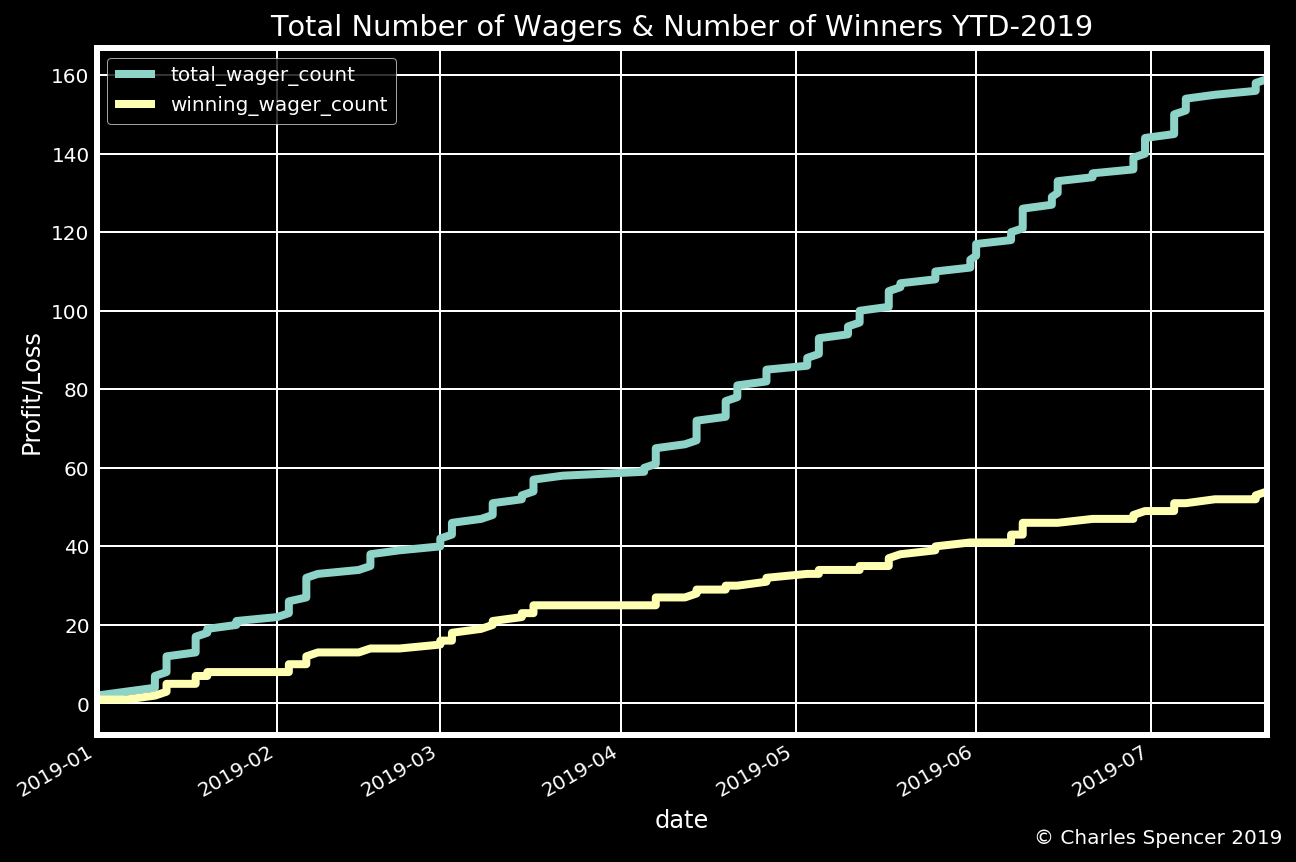

In [608]:
# Screen wagering on favorites which pay more than our fair odds (win_div_pred) results in these bets 
# of which nearly nearly 40% are winnners  

plt.style.use('dark_background')

x = 'date'
y = (['total_wager_count', 'winning_wager_count'])
accumualted_profit_loss.plot.line(x, y)
plt.title('Total Number of Wagers & Number of Winners YTD-2019')
plt.ylabel('Profit/Loss')
plt.gcf().set_size_inches(9, 6)
plt.grid(True)
plt.figtext(0.995, 0.01, u'\u00a9 Charles Spencer 2019', ha='right', va='bottom')
plt.tight_layout()


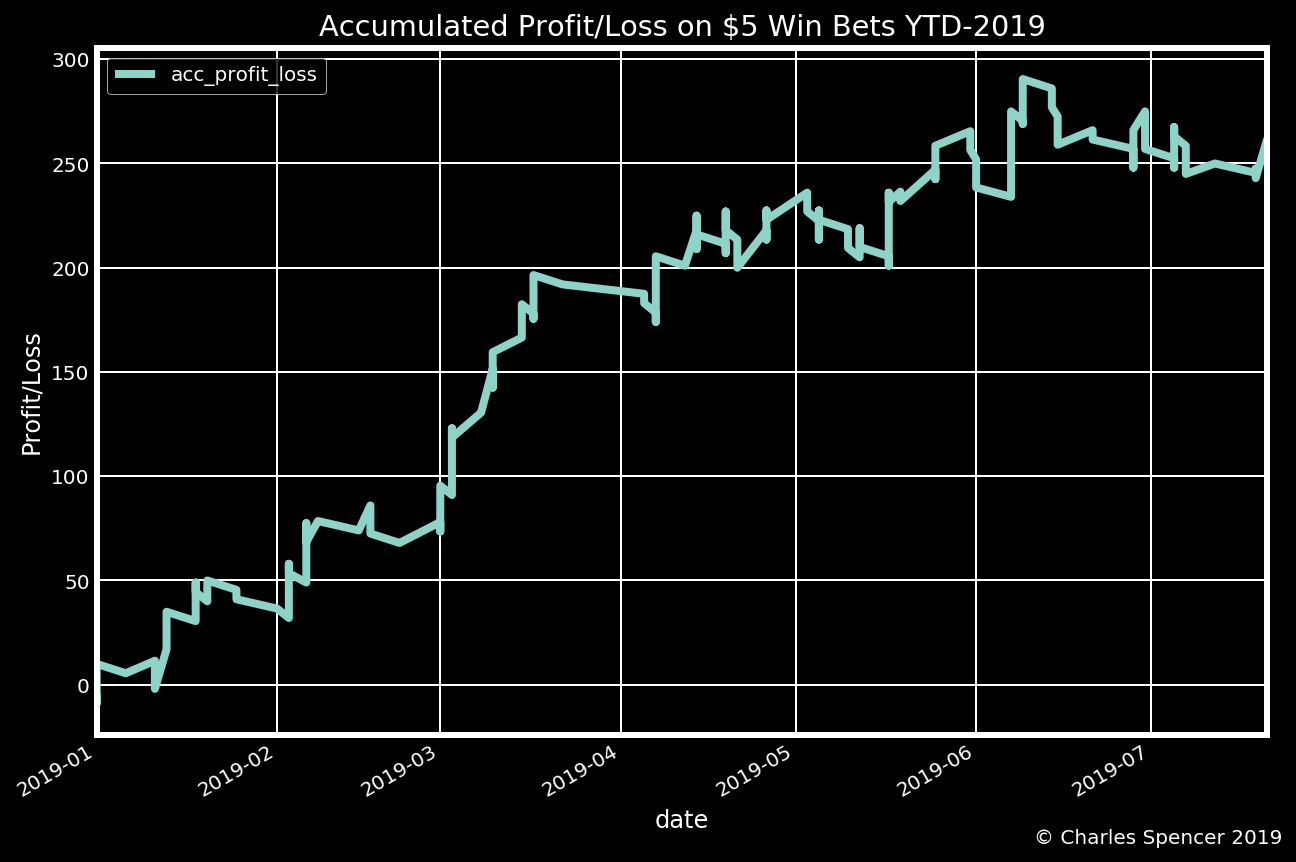

In [609]:
plt.style.use('dark_background')

accumualted_profit_loss.plot.line(x='date', y='acc_profit_loss')
plt.title('Accumulated Profit/Loss on $5 Win Bets YTD-2019')
plt.ylabel('Profit/Loss')
plt.gcf().set_size_inches(9, 6)
plt.grid(True)
plt.figtext(0.995, 0.01, u'\u00a9 Charles Spencer 2019', ha='right', va='bottom')
plt.tight_layout()

In [610]:
# save cleaned dataset back to folder
accumualted_profit_loss.to_csv('./datasets/accumualted_profit_loss.csv')

In [611]:
# Betting level:
# <21 $60
# <25 $161
# <27 $218     151; 101; 50
# <28 $244<<<< 163; 110; 53
# <29 $176     178; 125; 53
# <30 $182      182; 129; 54
# <35 $ 81 . . .  225; 169; 59
# <40 $ 7       
